# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<b>The objective is to develop a preidction regression model to estimate the price of used cars based on relevant features which are key value parameters for the customers. Price of a used car could vary based on make, model, year, engine type, condition, fuel efficiency etc.</b>

<b>This involves identifying and quantifying key predictors by using exploratory data analysis and feature engineering methodologies. The goal is to improve pricing accuracy based on insights provided by data and help in strategic data-driven decision making.</b>

<h2>2. Data Understanding</h2>

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

We would perform below steps to understand the data and indentify any quality issues:

1. Data preprocessing
   - Cleaning the data
   - Transforming the data
   - Preparing the data for model
2. Feature Engineering
   - Identify most important features
   - Perform PCA to reduce number of relevant features
   - Check relevance of higher order feature interaction   

In [1]:
%%capture
%pip install plotly
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install vininfo
%pip install vin
%pip install pyvin
%pip install aiohttp
%pip install category_encoders
%pip install mlflow
%pip install xgboost
%pip install catboost

In [2]:
# import required python libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import textwrap
import time
import mlflow

from vin import VIN
from sklearn import set_config
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

set_config(display='diagram')

In [3]:
nb_start_time = time.time()

In [4]:
mlflow.sklearn.autolog()

In [5]:
# Utility functions
# Wrap labels for x-axis
def wrap_labels(ax, width, n, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width, break_long_words=break_long_words))
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_xticklabels(labels, rotation=0)

<h3>1.1 Understanding variables & data</h3>

In [6]:
# Read dataset using pandas
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [7]:
# Check tail of the dataset
vehicles.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


In [8]:
# Check general stats of the dataset 
vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [9]:
# Check schema of the dataset, null values and data type of each column
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [10]:
# Check percentage of missing values for the columns which have more non-zero missing values
def find_missing_values_percentage(v):
    missing_values_all = v.isna().sum()
    missing_values = missing_values_all[missing_values_all > 0]
    missing_values_percentage = (missing_values / v.shape[0]) * 100
    return missing_values_percentage

missing_values_percent = find_missing_values_percentage(vehicles)
missing_values_percent

year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
dtype: float64

In [11]:
# Get unique values for each column
def get_unique_values(v):
    for col in v.columns:
        if v[col].isna().sum() > 0:
            unique_values = v[col].unique()
            print(f'Unique values for {col}: {unique_values}\n')

get_unique_values(vehicles) 

Unique values for year: [  nan 2014. 2010. 2020. 2017. 2013. 2012. 2016. 2019. 2011. 1992. 2018.
 2004. 2015. 2001. 2006. 1968. 2003. 2008. 2007. 2005. 1966. 2009. 1998.
 2002. 1999. 2021. 1997. 1976. 1969. 1995. 1978. 1954. 1979. 1970. 1974.
 1996. 1987. 2000. 1955. 1960. 1991. 1972. 1988. 1994. 1929. 1984. 1986.
 1989. 1973. 1946. 1933. 1958. 1937. 1985. 1957. 1953. 1942. 1963. 1977.
 1993. 1903. 1990. 1965. 1982. 1948. 1983. 1936. 1932. 1951. 1931. 1980.
 1967. 1971. 1947. 1981. 1926. 1962. 1975. 1964. 1934. 1952. 1940. 1959.
 1950. 1930. 1956. 1922. 1928. 2022. 1901. 1941. 1924. 1927. 1939. 1923.
 1949. 1961. 1935. 1918. 1900. 1938. 1913. 1916. 1943. 1925. 1921. 1915.
 1945. 1902. 1905. 1920. 1944. 1910. 1909.]

Unique values for manufacturer: [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubis

<h3>1.2 Data type transformation</h3>

In [12]:
# Convert object data type to string type
def convert_feature_dtype():
    for col in vehicles.select_dtypes(include='object').columns:
        vehicles[col] = vehicles[col].astype('string')

convert_feature_dtype()
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  string 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  string 
 5   model         421603 non-null  string 
 6   condition     252776 non-null  string 
 7   cylinders     249202 non-null  string 
 8   fuel          423867 non-null  string 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  string 
 11  transmission  424324 non-null  string 
 12  VIN           265838 non-null  string 
 13  drive         296313 non-null  string 
 14  size          120519 non-null  string 
 15  type          334022 non-null  string 
 16  paint_color   296677 non-null  string 
 17  state         426880 non-null  string 
dtypes: f

### Summary

* Dataset size is 426880 X 18.
* Many columns have missing values.
* Size column have ~72%+ values missing.
* We performed data type transformation to convert object data type to string type

<h2>2. Data Preparation</h2>

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

<h3>2.1 Data Wrangling</h3>

In [13]:
# Drop columns
# Drop id, as it is not useful for our analysis
# Drop size column as ~72% of the values are missing.
vehicles_df = vehicles.drop(['id', 'size'], axis=1)
vehicles_df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,sedan,<NA>,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,<NA>,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,<NA>,diesel,4174.0,clean,other,1GYFZFR46LF088296,<NA>,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,sedan,silver,wy
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,<NA>,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,coupe,<NA>,wy


<Axes: >

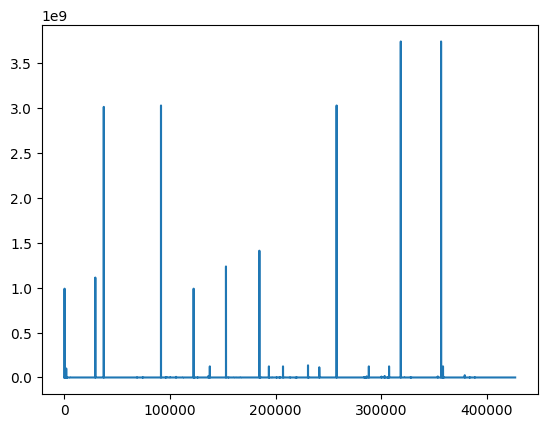

In [14]:
# Visualize price column to understand if there are outliers
vehicles_df['price'].plot()

In [15]:
# Apply VIN based imputation for year, make, model and vehicle type columns
def fill_vehicle_year(row):
    try:
        vin = VIN(row.VIN)
        return vin.model_year
    except BaseException:
        return row.year

def fill_vehicle_manufacturer(row):
    try:
        vin = VIN(row.VIN)
        return vin.make.lower()
    except BaseException:
        return row.manufacturer

def fill_vehicle_model(row):
    try:
        vin = VIN(row.VIN)
        return vin.model.lower()
    except BaseException:
        return row.model

def fill_vehicle_type(row):
    try:
        vin = VIN(row.VIN)
        return vin.body_class.lower()
    except BaseException:
        return row.type
        
def vin_based_imputation(col):
    if col == 'year':
        vehicles_year = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_year.index, col] = vehicles_year.apply(fill_vehicle_year, axis=1)
    elif col == 'manufacturer':
        vehicles_make = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_make.index, col] = vehicles_make.apply(fill_vehicle_manufacturer, axis=1)
    elif col == 'model':
        vehicles_model = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_model.index, col] = vehicles_model.apply(fill_vehicle_model, axis=1)
    elif col == 'type':
        vehicles_type = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_type.index, col] = vehicles_type.apply(fill_vehicle_type, axis=1)
    return vehicles_df
    
vehicles_df = vin_based_imputation('year')
vehicles_df = vin_based_imputation('manufacturer')
vehicles_df = vin_based_imputation('model')
types = vehicles_df['type'].unique()
vehicles_df = vin_based_imputation('type')
vehicles_df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,sedan,<NA>,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,<NA>,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,<NA>,diesel,4174.0,clean,other,1GYFZFR46LF088296,<NA>,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,sedan,silver,wy
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,<NA>,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,coupe,<NA>,wy


In [16]:
missing_values_percent = find_missing_values_percentage(vehicles_df)
missing_values_percent

year             0.044978
manufacturer     2.837566
model            0.871674
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
type            15.975216
paint_color     30.501078
dtype: float64

In [17]:
# Drop rows where nan
def drop_nan_rows(vehicles_df, col):
    total_rows = vehicles_df.shape[0]
    vehicles_df = vehicles_df[vehicles_df[col].notna()]
    not_nan_count = len(vehicles_df)
    print(f'Total rows: {total_rows}')
    print(f'Rows dropped with {col}=NaN : {total_rows - not_nan_count}')
    return vehicles_df

In [18]:
# Drop rows where year and odometer is nan
vehicles_df = drop_nan_rows(vehicles_df, 'year')
vehicles_df = drop_nan_rows(vehicles_df, 'odometer')
vehicles_df.head()

Total rows: 426880
Rows dropped with year=NaN : 192
Total rows: 426688
Rows dropped with odometer=NaN : 4331


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al


In [19]:
# Remove outliers for price, odometer, year
def remove_outliers(vehicles_df):
    Q1 = vehicles_df['price'].quantile(0.25)
    median = vehicles_df['price'].quantile(0.50)
    Q3 = vehicles_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows within bounds
    vehicles_df['price'] = np.where(vehicles_df['price'] > upper_bound, median, np.where(vehicles_df['price'] < lower_bound, median, vehicles_df['price']))

    # Impute zero value of price with median
    filter_price_zero = (vehicles_df['price'] == 0) & (vehicles_df['condition'].notna()) & (vehicles_df['title_status'].notna())
    vehicles_price_zero_df = vehicles_df[filter_price_zero]    
    vehicles_df.loc[vehicles_price_zero_df.index, 'price'] = median

    # Drop rows where price=0 and (condition=nan or title_status=nan)
    drop_price_zero = ((vehicles_df['price'] == 0) & ((vehicles_df['condition'].isna()) | (vehicles_df['title_status'].isna())))
    vehicles_drop_price_zero_df = vehicles_df[drop_price_zero]   
    total_rows = vehicles_df.shape[0]
    vehicles_df = vehicles_df.drop(vehicles_drop_price_zero_df.index)
    print(f'Total rows: {total_rows}')
    print(f'Rows dropped with price=0 & (condition=NaN | title=NaN) : {total_rows - vehicles_df.shape[0]}')

    # Removing outliers by Capping:
    for col in ['odometer', 'year']:
      upper_limit = vehicles_df[col].quantile(0.99)
      vehicles_df[col] = np.where(vehicles_df[col] > upper_limit, upper_limit, vehicles_df[col])
    return vehicles_df

vehicles_df = remove_outliers(vehicles_df)
vehicles_df.head()

Total rows: 422357
Rows dropped with price=0 & (condition=NaN | title=NaN) : 21100


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
27,auburn,33590.0,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al
28,auburn,22590.0,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al
29,auburn,39590.0,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al
30,auburn,30990.0,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al
31,auburn,15000.0,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al


In [20]:
# Data fix for model value=1500 based on manufactures and model
def fix_car_model():
    model_ram_df = vehicles_df[(vehicles_df['manufacturer'] == 'ram') & (vehicles_df['model'] == '1500')]
    model_gmc_df = vehicles_df[(vehicles_df['manufacturer'] == 'gmc') & (vehicles_df['model'] == '1500')]
    model_chevrolet_df = vehicles_df[(vehicles_df['manufacturer'] == 'chevrolet') & (vehicles_df['model'] == '1500')]

    vehicles_df.loc[model_ram_df.index, 'model'] = '1500 laramie'
    vehicles_df.loc[model_gmc_df.index, 'model'] = 'sierra 1500'
    vehicles_df.loc[model_chevrolet_df.index, 'model'] = 'silverado 1500'
    return vehicles_df

vehicles_df = fix_car_model()

In [21]:
vehicles['type'].unique()

<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string

In [22]:
# Convert year from float to integer
vehicles_df['year'] = vehicles_df['year'].astype('int64')
vehicles_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
27,auburn,33590.0,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al
28,auburn,22590.0,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al
29,auburn,39590.0,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al
30,auburn,30990.0,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al
31,auburn,15000.0,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al


In [23]:
# Fix car type data
def fix_car_type():
    type_sport_df = vehicles_df[vehicles_df['type']== 'sport utility vehicle (suv)/multi-purpose vehicle (mpv)']
    type_cuv_df = vehicles_df[vehicles_df['type']== 'crossover utility vehicle (cuv)']
    type_van_df = vehicles_df[vehicles_df['type']== 'step van / walk-in van']
    type_chasis_df = vehicles_df[vehicles_df['type']== 'incomplete - chassis cab (single cab)']
    type_sut_df = vehicles_df[vehicles_df['type']== 'sport utility truck (sut)']
    type_hatchback_df = vehicles_df[vehicles_df['type']== 'hatchback/liftback/notchback']
    type_minivan_df = vehicles_df[vehicles_df['type']== 'minivan']
    type_sedan_df = vehicles_df[vehicles_df['type']== 'sedan/saloon']

    vehicles_df.loc[type_sport_df.index, 'type'] = 'SUV'
    vehicles_df.loc[type_cuv_df.index, 'type'] = 'CUV'
    vehicles_df.loc[type_van_df.index, 'type'] = 'van'
    vehicles_df.loc[type_chasis_df.index, 'type'] = 'chassis cab'
    vehicles_df.loc[type_sut_df.index, 'type'] = 'SUT'
    vehicles_df.loc[type_hatchback_df.index, 'type'] = 'hatchback'
    vehicles_df.loc[type_minivan_df.index, 'type'] = 'mini-van'
    vehicles_df.loc[type_sedan_df.index, 'type'] = 'sedan'
    return vehicles_df

vehicles_df = fix_car_type()
vehicles_df['type'].value_counts()

type
sedan                    86420
SUV                      79727
pickup                   47616
truck                    32003
other                    20268
coupe                    19011
hatchback                17038
wagon                    10442
van                       8368
convertible               7512
mini-van                  5491
cargo van                  635
offroad                    609
bus                        517
CUV                        310
convertible/cabriolet      247
truck-tractor              117
SUT                         51
fire apparatus              36
roadster                    16
chassis cab                  1
Name: count, dtype: Int64

In [24]:
# Transform and fix cylinders column
# Change cyclinders to numeric column
vehicles_df['num_cylinders'] = 0

def transform_cylinders(vehicles_df):
    v8_df = vehicles_df[vehicles_df['cylinders'] == '8 cylinders']
    v6_df = vehicles_df[vehicles_df['cylinders'] == '6 cylinders']
    v4_df = vehicles_df[vehicles_df['cylinders'] == '4 cylinders']
    v5_df = vehicles_df[vehicles_df['cylinders'] == '5 cylinders']
    v3_df = vehicles_df[vehicles_df['cylinders'] == '3 cylinders']
    v10_df = vehicles_df[vehicles_df['cylinders'] == '10 cylinders']
    v12_df = vehicles_df[vehicles_df['cylinders'] == '12 cylinders']
    v_other_df = vehicles_df[vehicles_df['cylinders'] == 'other']

    vehicles_df.loc[v8_df.index , 'num_cylinders'] = 8
    vehicles_df.loc[v6_df.index , 'num_cylinders'] = 6
    vehicles_df.loc[v4_df.index , 'num_cylinders'] = 4
    vehicles_df.loc[v5_df.index , 'num_cylinders'] = 5
    vehicles_df.loc[v3_df.index , 'num_cylinders'] = 3
    vehicles_df.loc[v10_df.index , 'num_cylinders'] = 10
    vehicles_df.loc[v12_df.index , 'num_cylinders'] = 12
    vehicles_df.loc[v_other_df.index , 'num_cylinders'] = np.nan
    return vehicles_df

vehicles_df = transform_cylinders(vehicles_df)
vehicles_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,num_cylinders
27,auburn,33590.0,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al,8.0
28,auburn,22590.0,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al,8.0
29,auburn,39590.0,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al,8.0
30,auburn,30990.0,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al,8.0
31,auburn,15000.0,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al,6.0


In [25]:
vehicles_df['num_cylinders'].unique()

array([ 8.,  6.,  0.,  4.,  5., nan,  3., 10., 12.])

In [26]:
# Set number of cyclinders for electric cars to zero
def fix_cylinders_for_electric_vehicle(vehicles_df):
    v_fuel_electric = vehicles_df[(vehicles_df['fuel'] == 'electric')]
    vehicles_df.loc[v_fuel_electric.index , 'num_cylinders'] = 0
    return vehicles_df

vehicles_df = fix_cylinders_for_electric_vehicle(vehicles_df)
vehicles_df[(vehicles_df['fuel'] == 'electric')]['num_cylinders'].unique()

array([0.])

In [27]:
#Perform ordinal encoding for title_status, condition, drive and vehicle type of vehicles
def ordinal_encode(vehicles_df, col, categories): 
    # Create encoder
    encoder = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
    
    # Fit and transform
    vehicles_df[f'vehicle_{col}'] = encoder.fit_transform(vehicles_df[[col]])
    return vehicles_df


#Define custom order
title_categories = [['parts only', 'missing', 'salvage', 'rebuilt', 'lien', 'clean']]  # ordered worst to best
vehicles_df = ordinal_encode(vehicles_df, 'title_status', title_categories)

condition_categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']] # ordered worst to best
vehicles_df = ordinal_encode(vehicles_df, 'condition', condition_categories)

drive_categories = [['fwd', 'rwd', '4wd']] # ordered worst to best
vehicles_df = ordinal_encode(vehicles_df, 'drive', drive_categories)

type_categories = [['other', 'mini-van', 'hatchback', 'sedan', 'coupe', 'wagon', 'SUV', 'van', 'pickup', 'offroad', 'truck', 'convertible', 'bus']]
vehicles_df = ordinal_encode(vehicles_df, 'type', type_categories)

In [28]:
# Find interaction between features
def find_feature_interaction(vehicles_df):
    vehicles_df = vehicles_df.reset_index(drop=True)
    vehicles_df['vehicle_age'] = (2025 - vehicles_df['year']).astype('float64')
    vehicles_df['log_vehicle_age'] = np.log1p(vehicles_df['vehicle_age'])
    vehicles_df['vehicle_age_odometer_ratio'] = vehicles_df['odometer'] / vehicles_df['vehicle_age'].replace(0, 1)
    vehicles_df['vehicle_age_condition'] = vehicles_df['vehicle_age'] * vehicles_df['vehicle_condition']
    vehicles_df['title_good_condition'] = vehicles_df['vehicle_title_status'] * vehicles_df['vehicle_condition']
    # vehicles_df['high_mileage_bad_condition'] = vehicles_df['odometer'] * vehicles_df['vehicle_condition']
    return vehicles_df

vehicles_df = find_feature_interaction(vehicles_df)
vehicles_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,num_cylinders,vehicle_title_status,vehicle_condition,vehicle_drive,vehicle_type,vehicle_age,log_vehicle_age,vehicle_age_odometer_ratio,vehicle_age_condition,title_good_condition
0,auburn,33590.0,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,...,8.0,5.0,2.0,-1.0,8.0,11.0,2.484907,5265.727273,22.0,10.0
1,auburn,22590.0,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,...,8.0,5.0,2.0,-1.0,8.0,15.0,2.772589,4748.600000,30.0,10.0
2,auburn,39590.0,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,...,8.0,5.0,2.0,-1.0,8.0,5.0,1.791759,3832.000000,10.0,10.0
3,auburn,30990.0,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,...,8.0,5.0,2.0,-1.0,8.0,8.0,2.197225,5140.500000,16.0,10.0
4,auburn,15000.0,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,...,6.0,5.0,3.0,1.0,10.0,12.0,2.564949,10666.666667,36.0,15.0


In [29]:
#Perform OHE for certain categorical columns
def OHE_encoding(v_df, col):
    dummies = pd.get_dummies(v_df[col], prefix=col, dtype='float64')
    return dummies

vehicles_df = pd.concat([vehicles_df, OHE_encoding(vehicles_df, 'transmission')], axis=1)
vehicles_df = pd.concat([vehicles_df, OHE_encoding(vehicles_df, 'fuel')], axis=1)
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401257 entries, 0 to 401256
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   region                      401257 non-null  string 
 1   price                       401257 non-null  float64
 2   year                        401257 non-null  int64  
 3   manufacturer                390346 non-null  string 
 4   model                       397790 non-null  string 
 5   condition                   250851 non-null  string 
 6   cylinders                   238799 non-null  string 
 7   fuel                        399012 non-null  string 
 8   odometer                    401257 non-null  float64
 9   title_status                393814 non-null  string 
 10  transmission                399729 non-null  string 
 11  VIN                         247236 non-null  string 
 12  drive                       279016 non-null  string 
 13  type          

### Summary of Data Wrangling

* Drop id column, as it is not useful for our analysis.
* Drop size column as ~72% of the values are missing.
* Apply VIN based imputation for year, make, model and vehicle type columns using python library (vin)
* Droped rows with NaN values which could not imputed.
  * 192 rows for year column
  * 4331 rows for odometer column
* Observed outliers in price column.
  * We used IQR to remove outliers from price column.
  * Impute zero value of price with median when condition != NaN and title_status != Nan
  * Drop rows where price=0 and (condition=nan or title_status=nan)
* Removed outliers above 99 percentile for price and odometer columns.
* Impute vehicle model based on manufacturer and model where model value=1500.
* Convert year column data type from float to integer.
* Impute vehicle type by merging similar types of vehicle and abbreviating long names of car type.
* Transform cylinders by adding a new numeric column(num_cylinders).
  * Initialize num_cylinders colums with 0.
  * Assigned corropspnding numeric value of cylinders to num_cylinders column.
  * Set NaN for cylinders type of 'Other'. Used make, model and vehicle type to impute cylinders with NaN value.
  * Set num_cylinders for elctric vehicles to 0
* Performed ordinal encoding for below columns
  * title_status
  * condition
  * type
  * drive
* Added new columns based on features interaction
  * vehicle_age: Absolute age of the vehicle in years.
  * log_vehicle_age: Vehicle does not decline linearly. So, log of age represents depreciation more accurately.
  * vehicle_age_odometer_ratio: (Vehicle wear rate) Ratio of odometer and vehicle age ratio
  * vehicle_age_condition: Helps identify if older cars are in surprisingly good/bad condition.
  * title_good_condition: Clean + good condition = better resale value.

<h3>2.2 Data Visualization</h3>

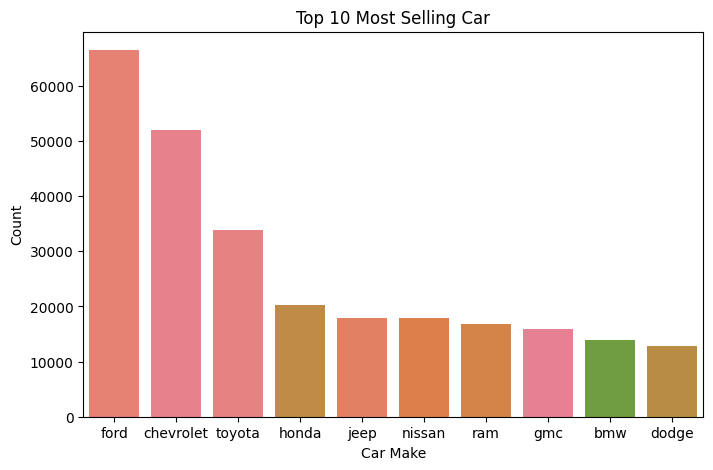

In [30]:
# Top 10 selling cars
top10 = vehicles_df['manufacturer'].value_counts()[:10]

# Create a count plot to visualize the top 10 car
plt.figure(figsize=(8, 5))
sns.countplot(x='manufacturer', data=vehicles_df, order=top10.index, hue='manufacturer')

# Set labels and title for the plot
plt.xlabel('Car Make')
plt.ylabel('Count')
plt.title('Top 10 Most Selling Car')

# Display the plot
plt.savefig('images/top10_selling_car.png')
plt.show()

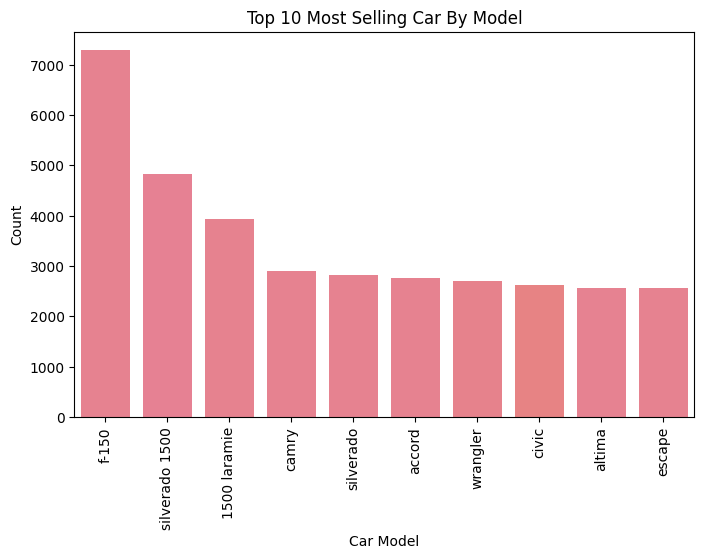

In [31]:
# Top 10 selling cars by model
top10model = vehicles_df['model'].value_counts()[:10]

# Create a count plot to visualize the top 10 car
plt.figure(figsize=(8, 5))
sns.countplot(x='model', data=vehicles_df, order=top10model.index, hue='model')

# Set labels and title for the plot
plt.xlabel('Car Model')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Top 10 Most Selling Car By Model')

# Display the plot
plt.savefig('images/top10_selling_car_by_model.png')
plt.show()

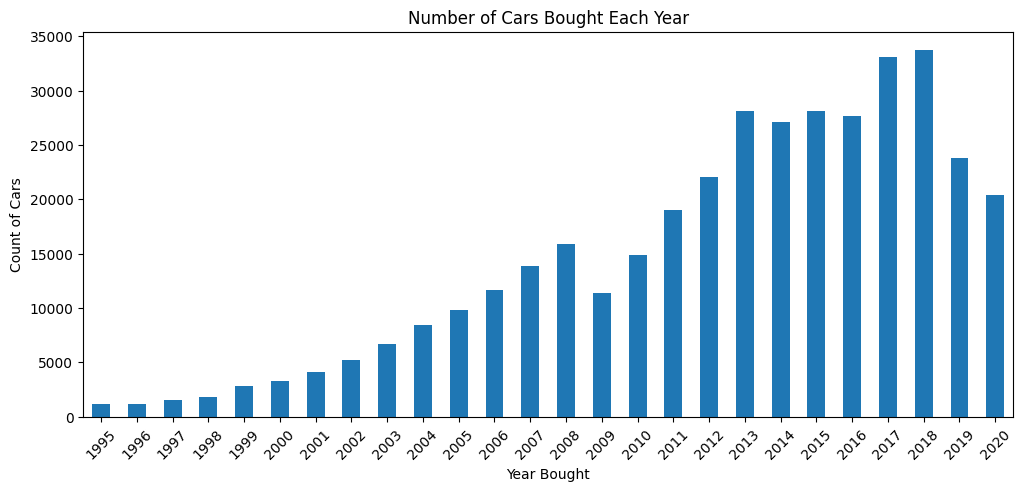

In [32]:
# Bar plot visualization for Number of Cars Bought Each Year During Last 25 Years
# Set the figure size for the plot
plt.figure(figsize=(12, 5))

# Group the data by the 'Year' column and count the number of occurrences for each year
yearly_counts = vehicles_df[vehicles_df['year'] >= 1995].groupby('year').count()['manufacturer']
yearly_counts

# Create a bar plot to visualize the count of cars bought in each year
yearly_counts.plot(kind='bar')

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Set labels and title for the plot
plt.xlabel('Year Bought')
plt.ylabel('Count of Cars')
plt.title('Number of Cars Bought Each Year')

# Display and save the plot
plt.savefig('images/top10_selling_car_by_year.png')
plt.show()

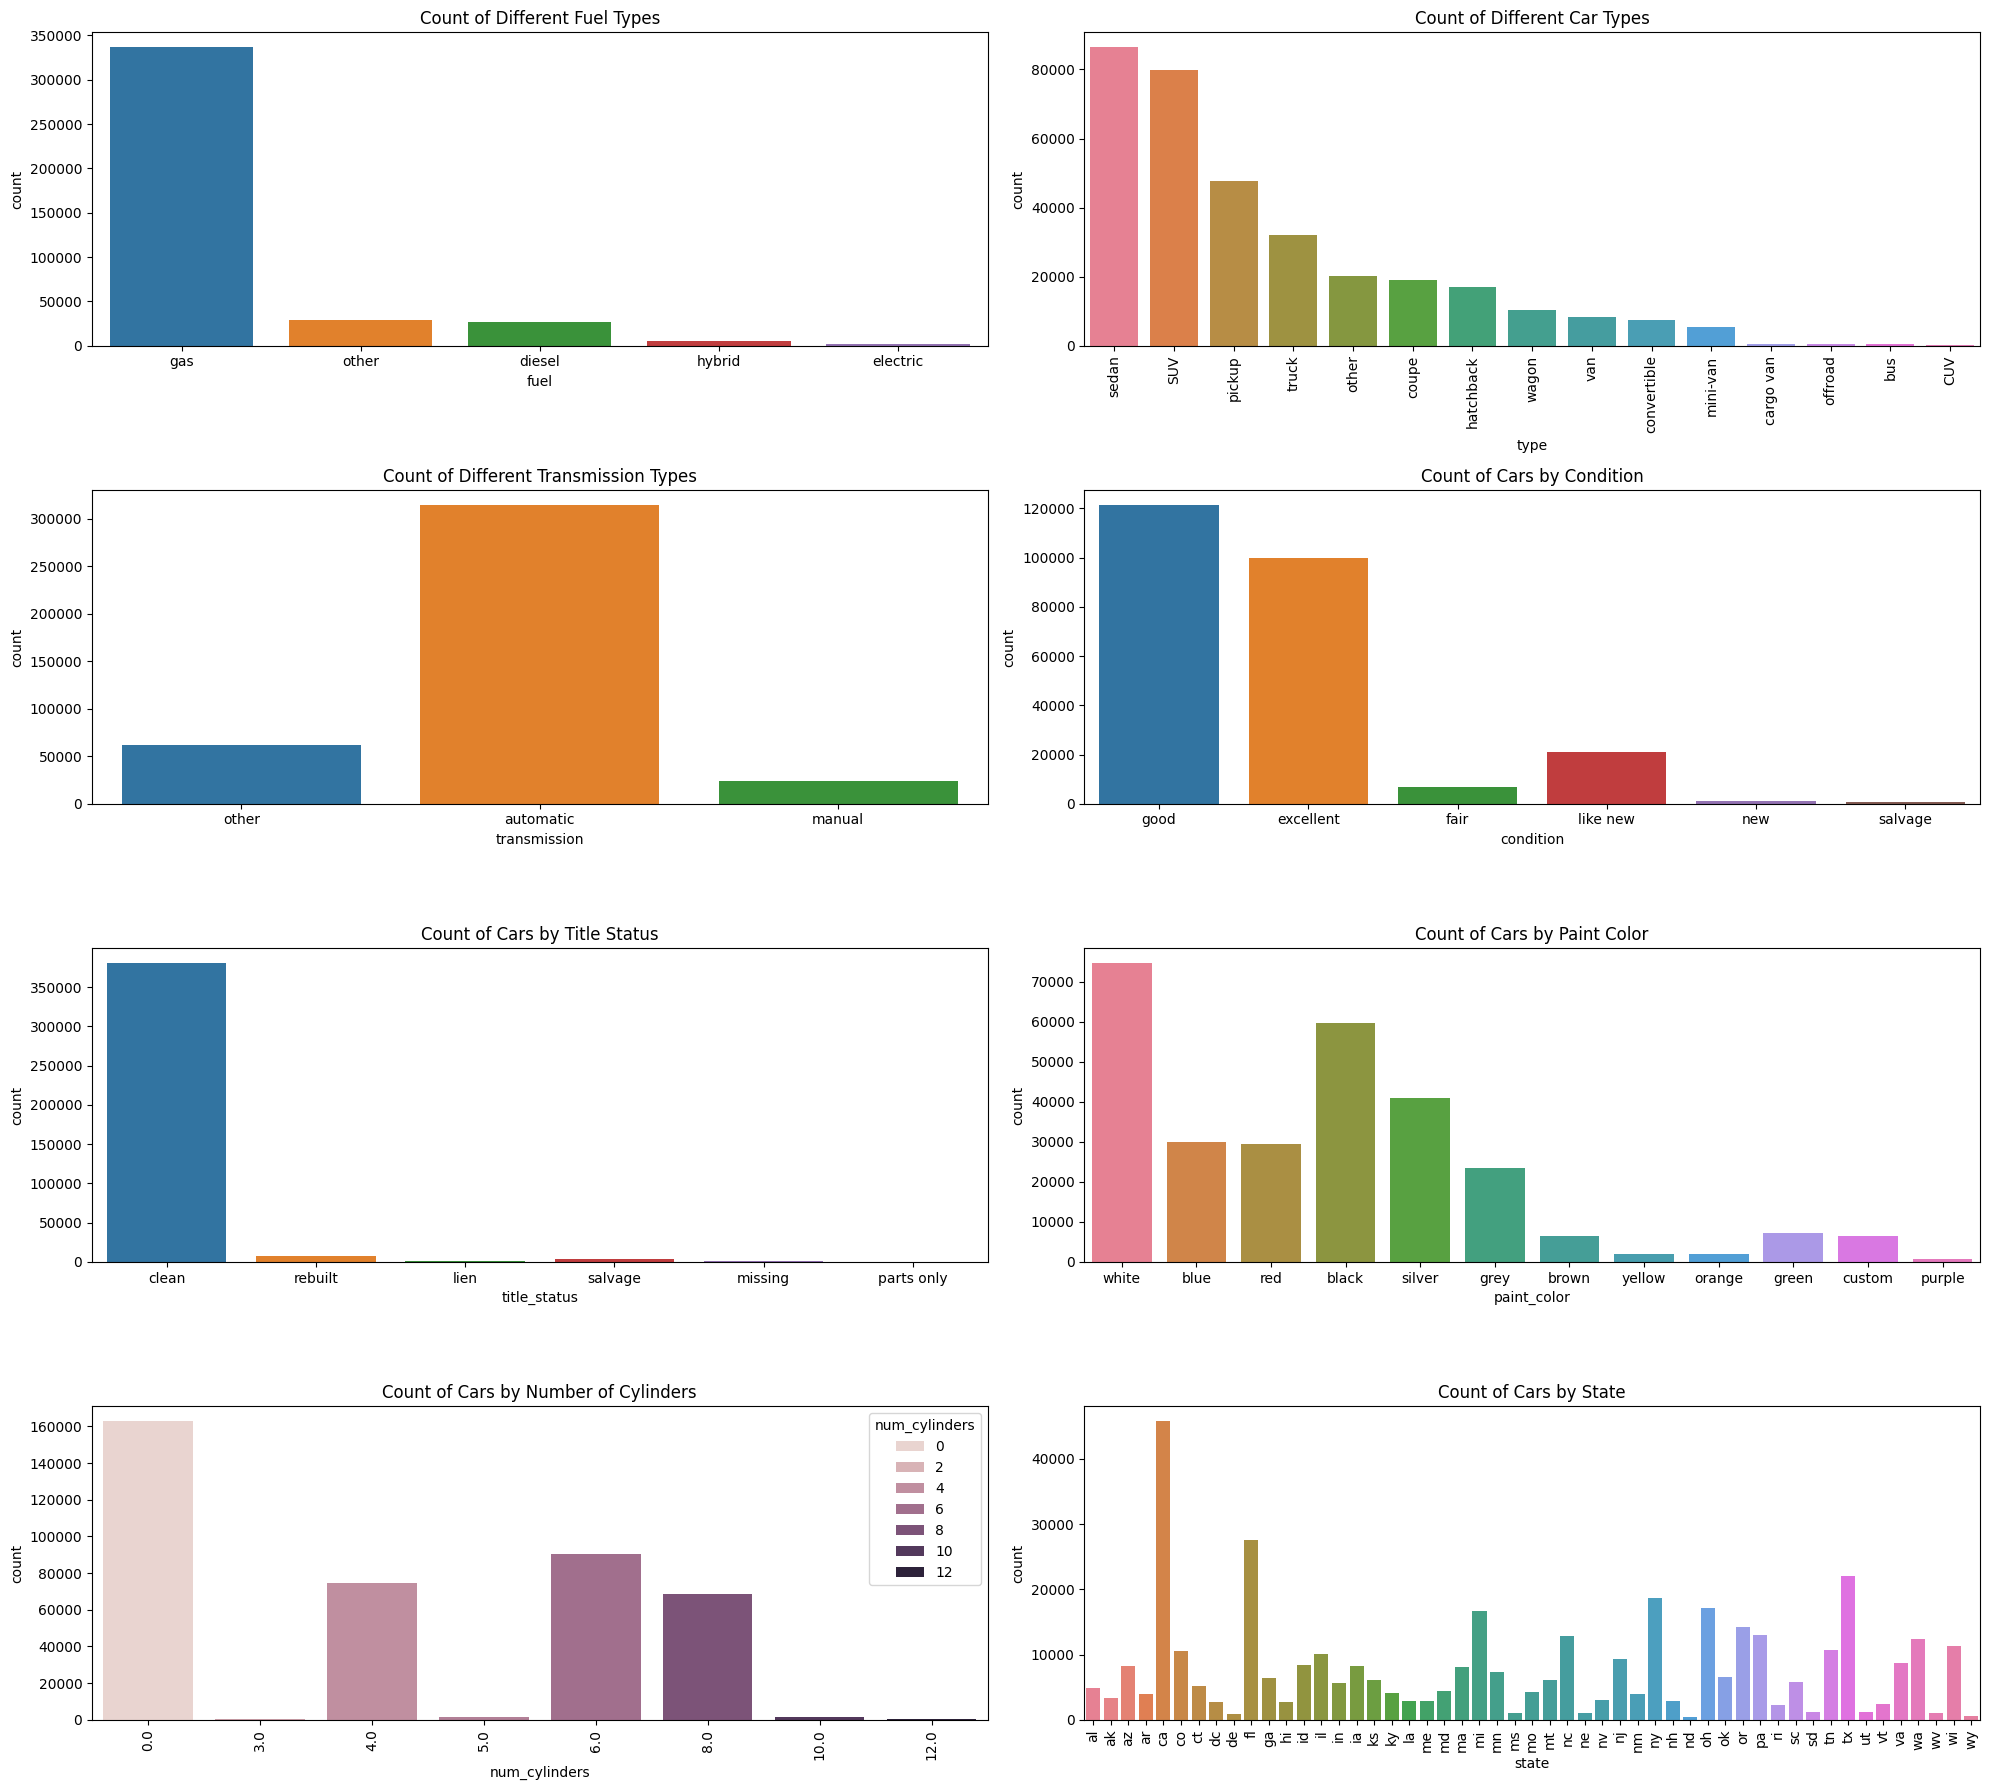

In [33]:
# Count plot visualization code for Categorical Variable
# Create a 4x2 subplot
plt.figure(figsize=(20,18))

# Subplot 1: Count of different Fuel Types
plt.subplot(4,2,1)
sns.countplot(data=vehicles_df, x='fuel', hue='fuel')
plt.title("Count of Different Fuel Types")

# Subplot 2: Count of different Car Types
plt.subplot(4,2,2)
type_df = vehicles_df['type'].value_counts()[:15].reset_index()
ax = sns.barplot(data=type_df, x='type', y='count', hue='type')
wrap_labels(ax, 10, len(type_df))
plt.title("Count of Different Car Types")
plt.xticks(rotation=90)

# Subplot 3: Count of different Transmission Types
plt.subplot(4,2,3)
sns.countplot(data=vehicles_df, x='transmission', hue='transmission')
plt.title("Count of Different Transmission Types")

# Subplot 4: Count Car Condition
plt.subplot(4,2,4)
sns.countplot(data=vehicles_df, x='condition', hue='condition')
plt.title("Count of Cars by Condition")

# Subplot 5: Count by title status
plt.subplot(4,2,5)
sns.countplot(data=vehicles_df, x='title_status', hue='title_status')
plt.title("Count of Cars by Title Status")

# Subplot 6: Count by Paint Color
plt.subplot(4,2,6)
sns.countplot(data=vehicles_df, x='paint_color', hue='paint_color')
plt.title("Count of Cars by Paint Color")

# Subplot 7: Count by Cylinders
plt.subplot(4,2,7)
sns.countplot(data=vehicles_df, x='num_cylinders', hue='num_cylinders')
plt.title("Count of Cars by Number of Cylinders")
plt.xticks(rotation=90)

# Subplot 8: Count by state
plt.subplot(4,2,8)
sns.countplot(data=vehicles_df, x='state', hue='state')
plt.title("Count of Cars by State")
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('images/count_plot_by_category_features.png')
plt.show()

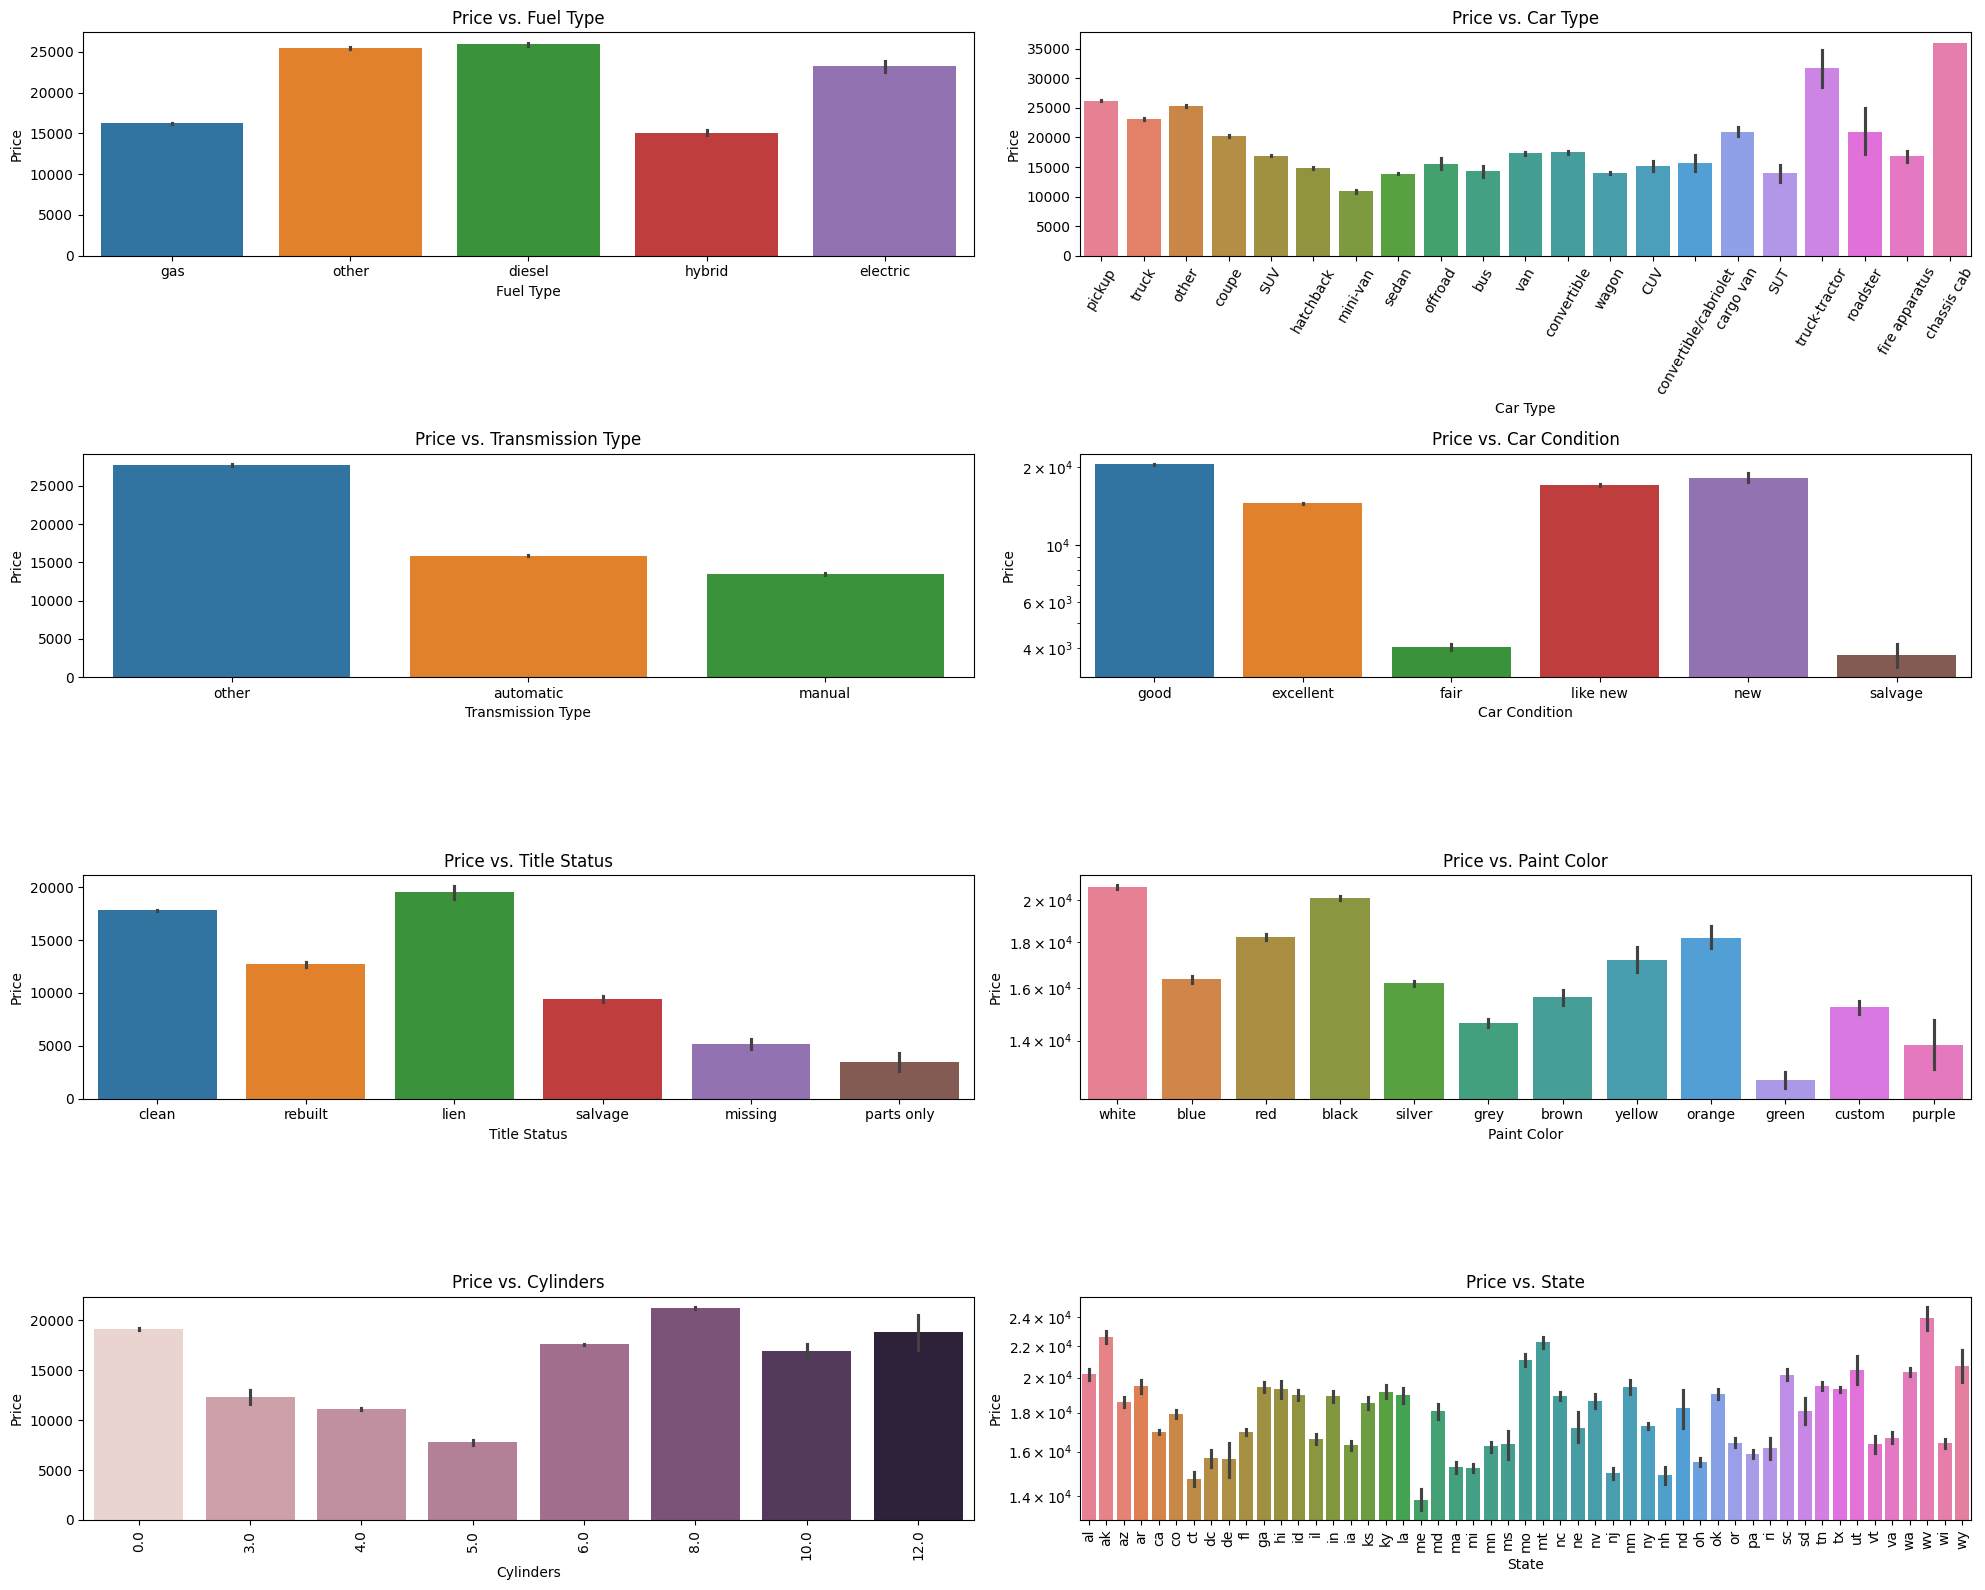

In [34]:
# Barplot visualization code for categorical variable vs target variable
# Create a 4x2 subplot
plt.figure(figsize=(20,16))

# Subplot 1: Barplot for Price vs. Fuel Type
plt.subplot(4,2,1)
sns.barplot(data=vehicles_df, x='fuel', y='price', hue='fuel')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.title('Price vs. Fuel Type')

# Subplot 2: Barplot for Price vs. Seller_Type
plt.subplot(4,2,2)
type_df = vehicles_df['type'].value_counts()
ax = sns.barplot(data=vehicles_df, x='type', y='price', hue='type')
wrap_labels(ax, 20, len(type_df))
plt.xticks(rotation=60)
plt.xlabel('Car Type')
plt.ylabel('Price')
plt.title('Price vs. Car Type')

# Subplot 3: Barplot for Price vs. Transmission
plt.subplot(4,2,3)
sns.barplot(data=vehicles_df, x='transmission', y='price', hue='transmission')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.title('Price vs. Transmission Type')

# Subplot 4: Barplot for Price vs. Condition
plt.subplot(4,2,4)
ax1 = sns.barplot(data=vehicles_df, x='condition', y='price', hue='condition')
ax1.set_yscale('log')
plt.xlabel('Car Condition')
plt.ylabel('Price')
plt.title('Price vs. Car Condition')

# Subplot 5: Count by title status
plt.subplot(4,2,5)
sns.barplot(data=vehicles_df, x='title_status', y='price', hue='title_status')
plt.xlabel('Title Status')
plt.ylabel('Price')
plt.title("Price vs. Title Status")

# Subplot 6: Count by Paint Color
plt.subplot(4,2,6)
ax2 = sns.barplot(data=vehicles_df, x='paint_color', y='price', hue='paint_color')
ax2.set_yscale('log')
plt.xlabel('Paint Color')
plt.ylabel('Price')
plt.title("Price vs. Paint Color")

# Subplot 7: Count by Cylinders
plt.subplot(4,2,7)
sns.barplot(data=vehicles_df, x='num_cylinders', y='price', hue='num_cylinders')
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.title("Price vs. Cylinders")
plt.legend().set_visible(False)
plt.xticks(rotation=90)

# Subplot 8: Count by state
plt.subplot(4,2,8)
ax3 = sns.barplot(data=vehicles_df, x='state', y='price', hue='state')
ax3.set_yscale('log')
plt.xlabel('State')
plt.ylabel('Price')
plt.title("Price vs. State")
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('images/price_vs_category_features.png')
plt.show()

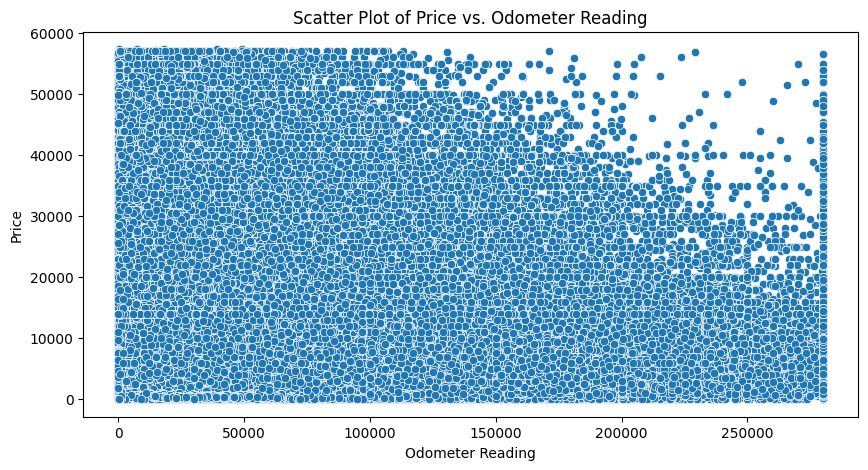

In [35]:
# Scatter plot visualization code for Odometer vs Price
# Set the figure size for the plot
plt.figure(figsize=(10,5))

# Create a scatter plot to visualize the relationship between Odometer and Price
ax4 = sns.scatterplot(data=vehicles_df, x='odometer', y='price')
# ax4.set_yscale('log')
# Set labels for the x and y axes
plt.xlabel('Odometer Reading')
plt.ylabel('Price')

# Add a title to the plot
plt.title('Scatter Plot of Price vs. Odometer Reading')

# Display the plot
plt.savefig('images/price_vs_odometer_scatter.png')
plt.show()

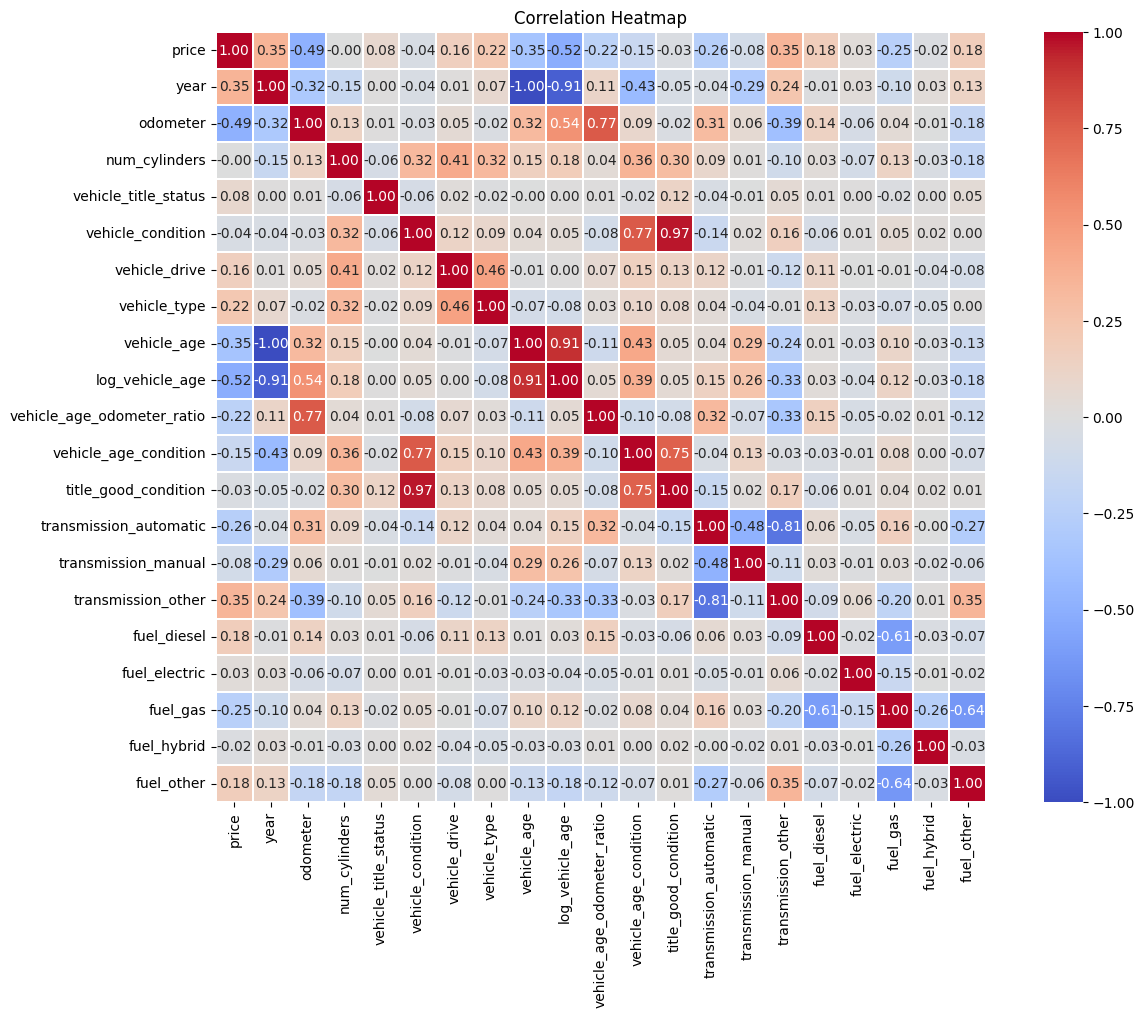

In [36]:
# Correlation Heatmap visualization code
# Set the size of the plot
plt.figure(figsize=(15, 10))

# Create a heatmap of the correlation matrix with annotations
numeric_df = vehicles_df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), annot=True, linewidths=0.1, fmt='.2f', square=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.savefig('images/features_heatmap.png')
plt.show()

### Summary of Data Visualization

* Ford, Chevrolet, Toyata are the top selling cars in the order.
* Ford F-150 is top selling model of the car.
* Most numbers of car were sold for the year 2018.
* Most important car features which are highly corrleated with most number of cars are as follows:
    * Most Valued Fuel Type: Gas
    * Most Valued Vehicle Type: Sedan
    * Most Valued Transmission: Automatic
    * Most Valued Condition: Good
    * Most Valued Title Status: Clean
    * Most Valued Color: White
    * Most Valued Cyclinders: Zero cylinders (Electric or Hydrogen fuel vehicles)
    * Top car seeling state: CA
* Most important car features which are highly corrleated with price of cars are as follows:
    * Fuel Type: Diesel and Other(Electric or Hydrogen Fuel)
    * Vehicle Type: Chasis-cab
    * Transmission Type: Other Type Transmission
    * Condition: Good
    * Title Status: Lien
    * Vehicle Color: White
    * Cyclinder configuration: 8 Cyclinders
    * State: West Virginia
* Scatter plot between odometer reading and price indicates that vehicle with lower odometer reading are sold at higher price.
* Correlation heatmap indicates that price is highly ngeatively correlated with vehicle age and odometer reading.

<h3>2.3 Data Cleaning/Transformation</h3>

In [37]:
# Apply Iterative Imputation for price column
# Root cause for R2 score 1.0
# def apply_IterativeImputer_price():
#     vehicles_df['price_impute'] = vehicles_df['price'].replace(0, np.nan)
#     imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),
#                            max_iter=5,
#                            random_state=42)
#     vehicles_df['price_impute'] = imputer.fit_transform(vehicles_df[[
#         'odometer', 'vehicle_age', 'log_vehicle_age', 'vehicle_age_odometer_ratio']])
#     return vehicles_df

# vehicles_df = apply_IterativeImputer_price()

# print(vehicles_df.shape)
# print(vehicles_df['price_impute'].isna().sum())

In [38]:
# Make a copy of dataset as a checkpoint
v_df = vehicles_df.copy()

In [39]:
v_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,vehicle_age_condition,title_good_condition,transmission_automatic,transmission_manual,transmission_other,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
0,auburn,33590.0,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,...,22.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,auburn,22590.0,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,...,30.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,auburn,39590.0,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,...,10.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,auburn,30990.0,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,...,16.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,auburn,15000.0,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,...,36.0,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [40]:
# Get electric vehicles
v_electric = v_df[v_df['fuel'] == 'electric']
v_electric['cylinders'].unique()

<StringArray>
[<NA>, '4 cylinders', 'other', '8 cylinders', '6 cylinders', '3 cylinders']
Length: 6, dtype: string

In [41]:
# Encode category columns based on JamesSteinEncoder and using RandomForestRegressor
def encode_cat_features(v, feature, target):
    X = v[[feature]]
    y = v[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build pipeline
    pipeline = Pipeline(steps=[
        ('encoder', JamesSteinEncoder(cols=feature)),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    v[f'{feature}_encoded'] = pipeline.predict(X)
    v[f'{feature}_encoded'].unique()
    
    return v

In [42]:
# Apply encoding for reamining category columns
v_df = encode_cat_features(v_df, 'region', 'price')
v_df = encode_cat_features(v_df, 'manufacturer', 'price')
v_df = encode_cat_features(v_df, 'model', 'price')
v_df = encode_cat_features(v_df, 'paint_color', 'price')
v_df = encode_cat_features(v_df, 'state', 'price')

2025/04/17 15:44:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '678e1549f39242ff887332b2a60b7abd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:44:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb83f77b3c9448d2bb237fd4a9d83ed4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:44:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'be6ff254f4a1490b9366967040b95baa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:45:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dbeb118de3da42c5a751771d2bd3e39d', which will track hyperparameters, performance metrics, model artifacts, and lineage i

In [43]:
# Apply IterativeImputer and RandomForestRegressor for cylinders
def apply_IterativeImputer_cylinders(col):
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),
                           max_iter=10,
                           random_state=42)
    v_df[col] = imputer.fit_transform(v_df[['manufacturer_encoded','model_encoded', 'vehicle_type', 'num_cylinders']])
    return v_df

v_df = apply_IterativeImputer_cylinders('num_cylinders')

2025/04/17 15:45:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4d89f6aec38a47f1b17258651aba5db4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:45:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a77a7dacc5354df9a5d7f3173e89e1b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:46:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b3ffc446f8934bccb6c2ed94507abaa4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:46:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b5b7d610769f44678186442974a6f712', which will track hyperparameters, performance metrics, model artifacts, and lineage i

In [44]:
missing_values_percent = find_missing_values_percentage(v_df)
missing_values_percent

manufacturer     2.719205
model            0.864035
condition       37.483707
cylinders       40.487269
fuel             0.559492
title_status     1.854921
transmission     0.380803
VIN             38.384626
drive           30.464515
type            16.154734
paint_color     29.479610
dtype: float64

In [45]:
# Drop unused columns after the transformation
def drop_not_useful_columns(v_df):
    cols = ['year', 'region', 'manufacturer', 'model', 'condition',
           'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
           'drive', 'type', 'paint_color', 'state']
    
    v_df_clean = v_df.drop(cols, axis=1)
    return v_df_clean

v_df_clean = drop_not_useful_columns(v_df)
v_df_clean.head()

# Make sure, we don't have any nan in the data
missing_values_percent = find_missing_values_percentage(v_df_clean)
missing_values_percent

Series([], dtype: float64)

In [46]:
v_df_clean.head()

,price,odometer,num_cylinders,vehicle_title_status,vehicle_condition,vehicle_drive,vehicle_type,vehicle_age,log_vehicle_age,vehicle_age_odometer_ratio,...,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,region_encoded,manufacturer_encoded,model_encoded,paint_color_encoded,state_encoded
0,33590.0,57923.0,21938.374907,5.0,2.0,-1.0,8.0,11.0,2.484907,5265.727273,...,0.0,0.0,1.0,0.0,0.0,26917.856871,21938.374907,35228.121289,20701.200640,20202.941272
1,22590.0,71229.0,18221.491349,5.0,2.0,-1.0,8.0,15.0,2.772589,4748.600000,...,0.0,0.0,1.0,0.0,0.0,26917.856871,18221.491349,22631.738779,16352.946248,20202.941272
2,39590.0,19160.0,18221.491349,5.0,2.0,-1.0,8.0,5.0,1.791759,3832.000000,...,0.0,0.0,1.0,0.0,0.0,26917.856871,18221.491349,34443.794112,18291.064420,20202.941272
3,30990.0,41124.0,16618.510294,5.0,2.0,-1.0,8.0,8.0,2.197225,5140.500000,...,0.0,0.0,1.0,0.0,0.0,26917.856871,16618.510294,34709.977550,18291.064420,20202.941272
4,15000.0,128000.0,19042.648083,5.0,3.0,1.0,10.0,12.0,2.564949,10666.666667,...,0.0,0.0,1.0,0.0,0.0,26917.856871,19042.648083,20057.528154,20135.601393,20202.941272


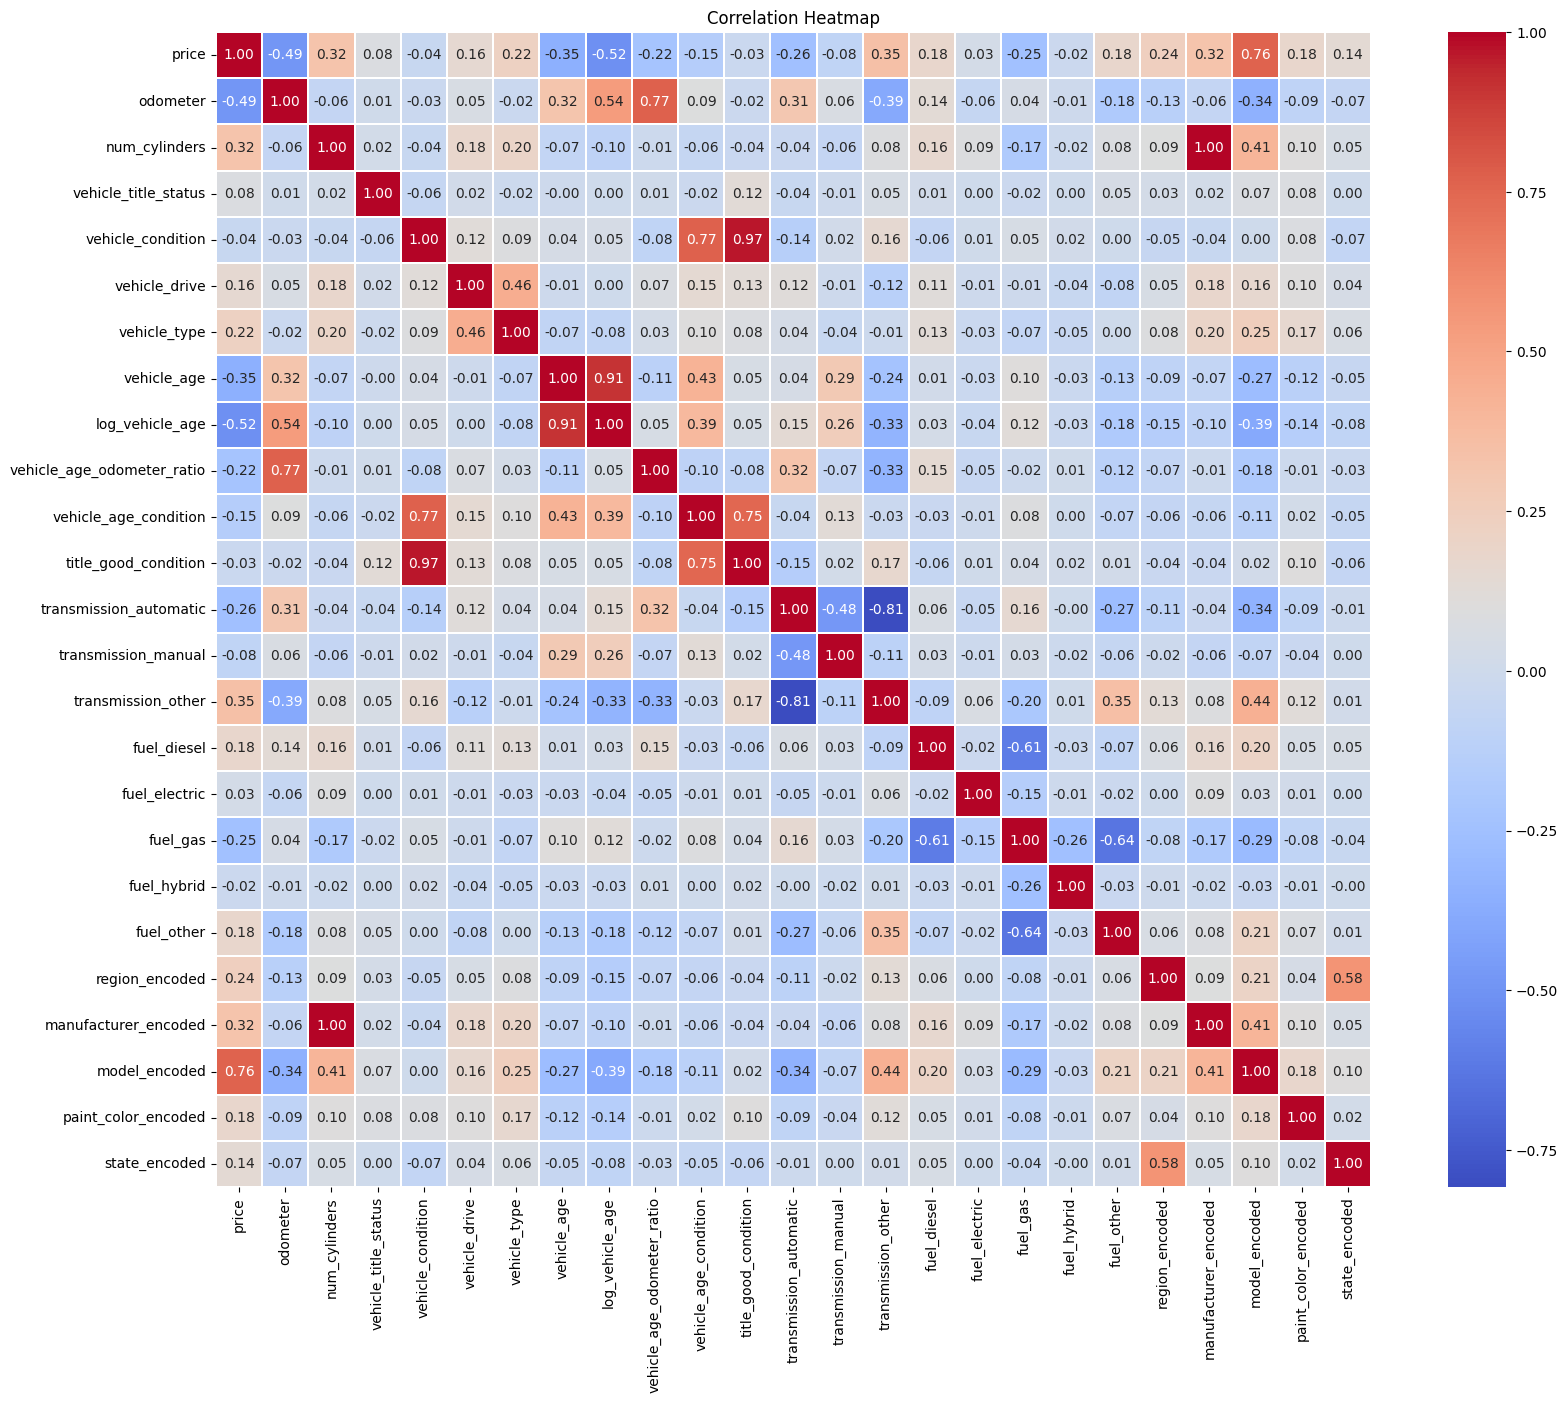

In [47]:
# Correlation Heatmap visualization code
# Set the size of the plot
plt.figure(figsize=(20, 15))

# Create a heatmap of the correlation matrix with annotations
corr_matrix = v_df_clean.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=0.1, fmt='.2f', square=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Heatmap")

# Display the plot
plt.savefig('images/corr_heatmap.png')
plt.show()

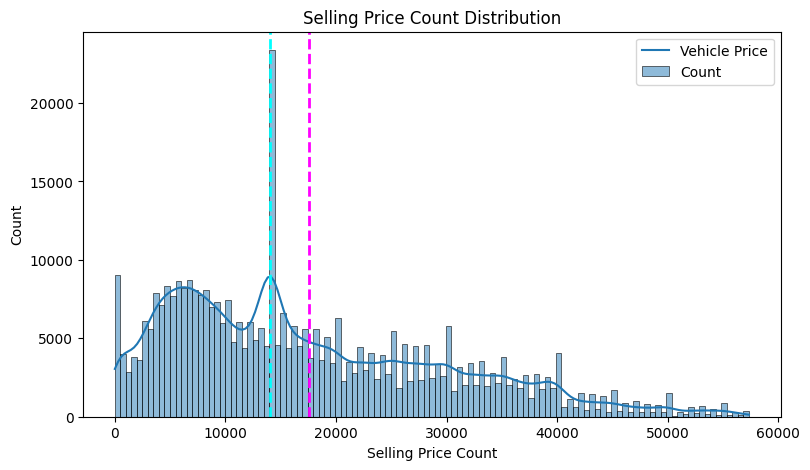

In [48]:
# Visualizing the distribution of the dependent variable - price
dependent_variable = ['price']
plt.figure(figsize=(9,5))
sns.histplot(v_df_clean[dependent_variable], kde=True)
plt.xlabel('Selling Price Count')
plt.title('Selling Price Count Distribution')
plt.legend(["Vehicle Price", "Count"])
plt.axvline(v_df_clean[dependent_variable[0]].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(v_df_clean[dependent_variable[0]].median(), color='cyan', linestyle='dashed', linewidth=2)
plt.savefig('images/vehicle_price_distribution.png')
plt.show()

### Summary of Data Cleaning and Transformation

* ~~Performed imputation using IterativeImputer with RandomForestRegressor for vehicle price column based on (odometer, price, vehicle_age, vehicle_age_odometer_ratio, vehicle_age_condition)~~ <b>Price imputation was causing data leakage.</b>
* Applied JamesSteinEncoder encoder with RandomForestRegressor for following features:
  * region
  * manufacturer
  * model
  * paint_color
  * state
* Performed imputation using IterativeImputer with RandomForestRegressor for following features:
  * manufacturer_encoded
  * model_encoded
  * vehicle_type
  * num_cylinders
* Dropped below redundant columns after applying imputation and encoding:
  * 'year', 'region', 'manufacturer', 'model', 'condition',
    'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
    'drive', 'type', 'paint_color', 'state'
* Some difference in mean and median of vehicle price indicates some level of variance in the dataset.

### 3. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [49]:
v_df_clean = shuffle(v_df_clean)
v_split_count = int(v_df_clean.shape[0] * 0.9)
data, data_valid = np.split(v_df_clean, [v_split_count], axis=0)
print(data.shape)
print(data_valid.shape)
X = data.drop('price', axis=1)
y = data['price']

(361131, 25)
(40126, 25)


/usr/local/Cellar/jupyterlab/4.3.5_1/libexec/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,odometer,num_cylinders,vehicle_title_status,vehicle_condition,vehicle_drive,vehicle_type,vehicle_age,log_vehicle_age,vehicle_age_odometer_ratio,vehicle_age_condition,...,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,region_encoded,manufacturer_encoded,model_encoded,paint_color_encoded,state_encoded
1526,35109.0,19794.591853,5.0,4.0,-1.0,-1.0,8.0,2.197225,4388.625000,32.0,...,0.0,0.0,1.0,0.0,0.0,17900.745055,19794.591853,17649.009256,20701.200640,20202.941272
250347,98732.0,18221.491349,5.0,3.0,2.0,8.0,11.0,2.484907,8975.636364,33.0,...,0.0,0.0,1.0,0.0,0.0,19940.143407,18221.491349,22631.738779,16352.946248,17302.212170
190924,76372.0,26379.498005,5.0,2.0,1.0,0.0,11.0,2.484907,6942.909091,22.0,...,0.0,0.0,1.0,0.0,0.0,17817.763360,26379.498005,35590.000000,20135.601393,15228.869045
64337,14140.0,26771.805141,5.0,-1.0,2.0,8.0,5.0,1.791759,2828.000000,-5.0,...,1.0,0.0,0.0,0.0,0.0,22472.303273,26771.805141,13990.000000,20701.200640,16988.743294
35765,30958.0,18221.491349,5.0,3.0,0.0,3.0,6.0,1.945910,5159.666667,18.0,...,0.0,0.0,1.0,0.0,0.0,15069.128173,18221.491349,7285.165212,16352.946248,16988.743294


In [51]:
len(X_train.columns)

24

In [52]:
# Find best model compexity
num_features = ['odometer', 'num_cylinders', 'vehicle_title_status',
       'vehicle_condition', 'vehicle_drive', 'vehicle_type',
       'log_vehicle_age', 'vehicle_age_odometer_ratio',
       'transmission_automatic', 'transmission_manual', 'transmission_other',
       'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'region_encoded', 'manufacturer_encoded',
       'model_encoded', 'paint_color_encoded', 'state_encoded']

def find_best_model_complexity(regressor, param_grid):
    preprocessor = ColumnTransformer(
        transformers=[
            ('transformer', Pipeline([ 
                ('scaler', RobustScaler()),
                ('poly', PolynomialFeatures())
            ]), num_features),
        ])
    
    pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('regressor', regressor)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid = param_grid,
        scoring = "neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        refit=True)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    cv_results = grid.cv_results_
    
    return best_model, cv_results

<h3>3.1 Linear Regression</h3>

In [53]:
# Linear Regression
start_time = time.time()
lr_param_grid = {
    'preprocessor__transformer__poly__degree': [1, 2], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True]
}
best_model_lr, cv_results_lr = find_best_model_complexity(LinearRegression(), lr_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:46:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b663d42271c84c1a948e09047b07f2f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:46:44 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🕒 Duration (seconds): 27.00128674507141


<h3>3.2 Ridge Regression</h3>

In [54]:
# Ridge Regression
start_time = time.time()
rcv_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__fit_intercept': [True, False],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'saga'],
    'regressor__tol': [1e-4, 1e-3, 1e-2]
}
best_model_rcv, cv_results_rcv = find_best_model_complexity(Ridge(), rcv_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:46:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c0150ca29b3946159f43ab60bf64e623', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:47:26 INFO mlflow.sklearn.utils: Logging the 5 best runs, 67 runs will be omitted.


🕒 Duration (seconds): 42.1295051574707


<h3>3.3 Lasso Regression</h3>

In [55]:
# Lasso Regression
start_time = time.time()
lcv_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__alpha': np.logspace(-6, 2, 10),
    'regressor__fit_intercept': [True, False],
    'regressor__warm_start': [True],
    'regressor__precompute': [True],
    'regressor__max_iter': [100000],
    'regressor__tol': [1e-3, 1e-2]
}
best_model_lcv, cv_results_lcv = find_best_model_complexity(Lasso(), lcv_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:47:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'de109621212e42758ba247e7468bee5f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:47:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 35 runs will be omitted.


🕒 Duration (seconds): 19.1256160736084


<h3>3.4 ElasticNet Regression</h3>

In [56]:
## ElasticNet Regression
start_time = time.time()
ecv_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__selection': ['cyclic', 'random'],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'regressor__fit_intercept': [True, False],
    'regressor__warm_start': [True],
    'regressor__precompute': [True],
    'regressor__max_iter': [100000],
    'regressor__tol': [1e-4, 1e-3]
}
best_model_ecv, cv_results_ecv = find_best_model_complexity(ElasticNet(), ecv_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:47:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '088b3f4931564a87b4a504e84eb92d43', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:48:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, 195 runs will be omitted.


🕒 Duration (seconds): 43.39992690086365


<h3>3.5 XGBRegressor</h3>

In [57]:
## XGBoost Regression
start_time = time.time()
xg_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__objective': ['reg:squarederror'],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}
best_model_xg, cv_results_xg = find_best_model_complexity(XGBRegressor(), xg_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:48:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b7f9f01af68443f19c56329b8abc876e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:49:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, 43 runs will be omitted.


🕒 Duration (seconds): 77.3677568435669


<h3>3.6 HistGradientBoostingRegressor</h3>

In [58]:
## HistGradientBoostingRegressor Regression
start_time = time.time()
hgb_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__min_samples_leaf': [20, 50],
    'regressor__max_iter': [100, 200],
    'regressor__max_depth': [None, 5, 10],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__l2_regularization': [0.0, 1.0],
    'regressor__random_state': [42],
    # CatBoostRegressor
    # 'regressor__silent': [True],
    # 'regressor__iterations': [100, 200],
    # 'regressor__depth': [4, 6, 8],
    # 'regressor__learning_rate': [0.01, 0.1],
    # 'regressor__l2_leaf_reg': [1, 3, 5]
}
best_model_hgb, cv_results_hgb = find_best_model_complexity(HistGradientBoostingRegressor(), hgb_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:49:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f8052f99e82b45f9af451951f174400c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:52:25 INFO mlflow.sklearn.utils: Logging the 5 best runs, 43 runs will be omitted.


🕒 Duration (seconds): 158.4186728000641


<h3>3.7 DecisionTreeRegressor</h3>

In [59]:
start_time = time.time()
dt_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__min_samples_split': [2, 10, 20],
    'regressor__min_samples_leaf': [1, 5, 10],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__ccp_alpha': [0.0, 0.01, 0.1],
    'regressor__random_state': [42]
}
best_model_dt, cv_results_dt = find_best_model_complexity(DecisionTreeRegressor(), dt_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

2025/04/17 15:52:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b4eec0c810cc4d568ed5a4a86544c782', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/17 15:55:50 INFO mlflow.sklearn.utils: Logging the 5 best runs, 319 runs will be omitted.


🕒 Duration (seconds): 205.77986598014832


### Summary of Modeling

* Shuffled the clean dataset and divide into 2 parts (9:1 ratio)
  * First data set us used for model training and testing
  * Second data set would be never seen dataset and would be used to validate model.
* Split first data set into train and test set using scikit-learn train_test_split() method
* Trained 6 types of models based on different regression algorithms.
  * LinearRegression
  * Ridge Regression
  * Lasso Regression
  * ElasticNet
  * XGBoostRegressor
  * HistGradientBoostingRegressor
* Performed hyperparameters tuning of the models using GridSearchCV to perform cross-validation and evaulate best performing model.

### 4. Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [60]:
# Create a score dataframe
score = pd.DataFrame(index = ['MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 
                              'MAE Train', 'MAE Test', 'R2 Train', 'R2 Test', 'Adjusted R2 Train', 'Adjusted R2 Test'])

In [61]:
# Plot permutation importance 
def plot_permutation_importance(perm_dfs, model):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=perm_dfs.reset_index(), x='Features', y='Permutation Importance Mean', hue='Permutation Importance Std', palette='viridis')
    ax.set_yscale('log')
    plt.xlabel("Features")
    plt.xticks(rotation=75)
    plt.ylabel(f"Permutation Importance for {model} model")
    plt.savefig(f'images/perm_importance_{model}')

<b>Adjusted R² is a modified version of the R² (coefficient of determination) that accounts for the number of independent variables (features) in your model. It penalizes the addition of irrelevant features, unlike R² which always increases (or stays the same) when new features are added—even if they don’t improve the model.</b>

In [62]:
# Adjusted R2 score
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - ((1 - r2) * (n - 1)) / (n - n_features - 1)

In [63]:
# Function for model evaluation
mse_train_models = []
mse_test_models = []
rmse_train_models = []
rmse_test_models = []
mae_train_models = []
mae_test_models = []
r2_train_models = []
r2_test_models = []
adjusted_r2_train_models = []
adjusted_r2_test_models = []

def evaluate_models(best_model, model_name, y_test, X_test, y_train, X_train):

    '''
      Print evaluation metrics based on y_test and y_pred
      Plot actual vs predicted values
      Plot important features
      Returns a list of the model scores
    '''
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculating Evaluation Matrix
    mse_train = mean_squared_error(y_train_pred, y_train)
    mse_test = mean_squared_error(y_test_pred, y_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adjusted_r2_train = adjusted_r2_score(y_train, y_train_pred, X_train.shape[1])
    adjusted_r2_test = adjusted_r2_score(y_test, y_test_pred, X_test.shape[1])

    mse_train_models.append(mse_train)
    mse_test_models.append(mse_test)
    rmse_train_models.append(rmse_train)
    rmse_test_models.append(rmse_test)
    mae_train_models.append(mae_train)
    mae_test_models.append(mae_test)
    r2_train_models.append(r2_train)
    r2_test_models.append(r2_test)
    adjusted_r2_train_models.append(adjusted_r2_train)
    adjusted_r2_test_models.append(adjusted_r2_test)

    # Printing Evaluation Matrix
    print("MSE Train:" , mse_train)
    print("MSE Test:" , mse_test)
    print("RMSE Train:" ,rmse_train)
    print("RMSE Test:" ,rmse_test)
    print("MAE Train:" ,mae_train)
    print("MAE Test:" ,mae_test)
    print("R2 Train:", r2_train)
    print("R2 Test:", r2_test)
    print("Adjusted R2 Train:", adjusted_r2_train)
    print("Adjusted R2 Test:", adjusted_r2_test)

    # plot actual and predicted values
    plt.figure(figsize=(12,4))
    plt.plot(np.array(y_test_pred)[:100], linestyle='-', marker='^')
    plt.plot(np.float64((y_test)[:100]))
    plt.legend(["Predicted", "Actual"])
    plt.title('Actual and Predicted Selling Price', fontsize=12)
    plt.savefig(f'images/predicted_vs_actual_price_for_{model_name}')

    results = permutation_importance(best_model, X_test, y_test)
    perm_df = pd.DataFrame({
      'perm_importance_mean': results.importances_mean,
      'perm_importance_std': results.importances_std
    }, index=X.columns).sort_values(by='perm_importance_mean', ascending=False)
    
    perm_df = perm_df.reset_index()
    perm_df.columns = ['Features', 'Permutation Importance Mean', 'Permutation Importance Std']
    
    # Feature importances
    plot_permutation_importance(perm_df, model_name)

    model_score = [mse_train, mse_test, rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test, adjusted_r2_train, adjusted_r2_test]
    return model_score

<h4>4.1 Evaluate LinearRegression model</h4>

MSE Train: 44241754.23859767
MSE Test: 44189895.969520666
RMSE Train: 6651.447529568107
RMSE Test: 6647.548117127146
MAE Train: 4322.278166283804
MAE Test: 4325.7260156314715
R2 Train: 0.7171490888908313
R2 Test: 0.7161468790088874
Adjusted R2 Train: 0.7171255897030515
Adjusted R2 Test: 0.7160525260144581
🕒 Duration (seconds): 17.159459114074707


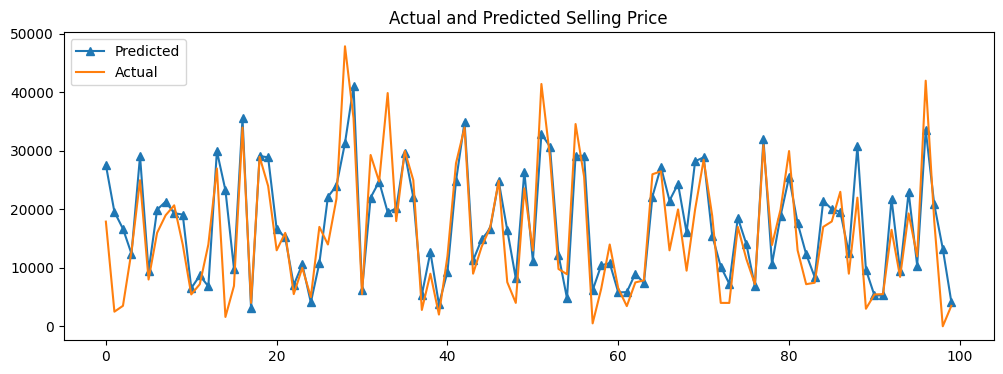

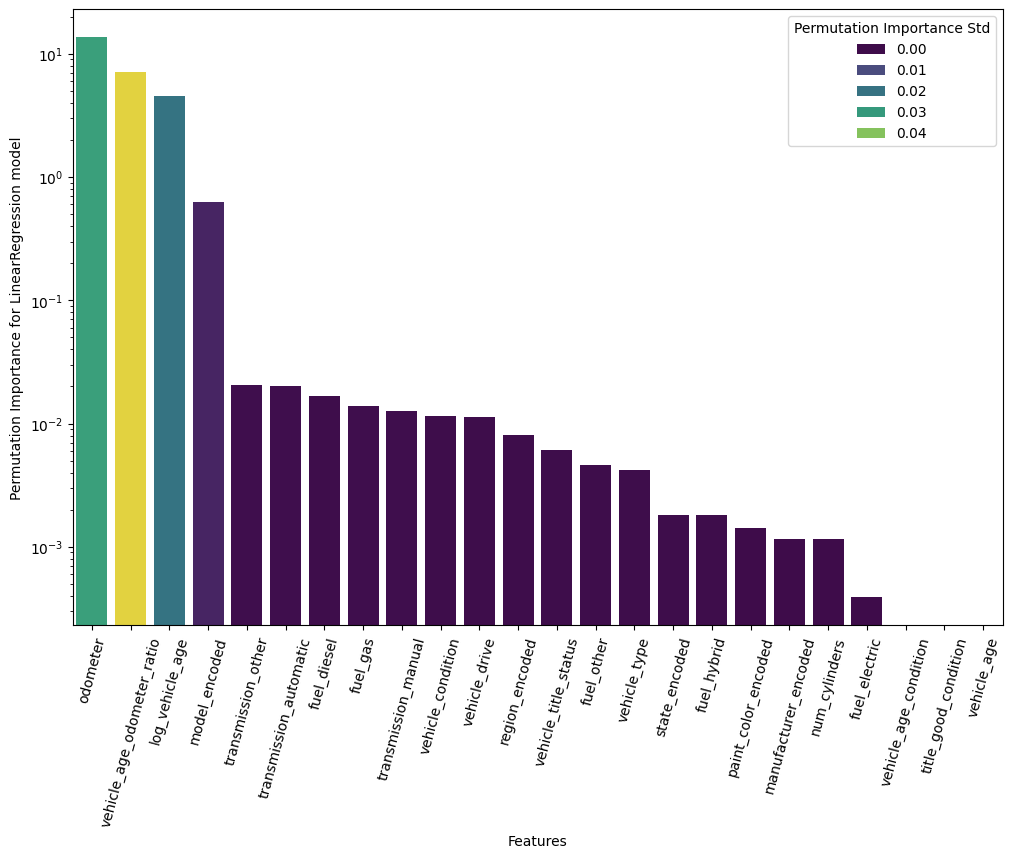

In [64]:
# Evaluate LinearRegression model
start_time = time.time()
linear_score = evaluate_models(best_model_lr, 'LinearRegression', y_test, X_test, y_train, X_train)
score['Linear Regressor'] = linear_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.2 Evaluate Ridge model</h4>

MSE Train: 49431452.52738118
MSE Test: 49067160.071148425
RMSE Train: 7030.750495315645
RMSE Test: 7004.795505305521
MAE Train: 4720.666210116481
MAE Test: 4707.670663108031
R2 Train: 0.6839697786526431
R2 Test: 0.6848178476371041
Adjusted R2 Train: 0.6839435229355009
Adjusted R2 Test: 0.684713080848695
🕒 Duration (seconds): 1.1466221809387207


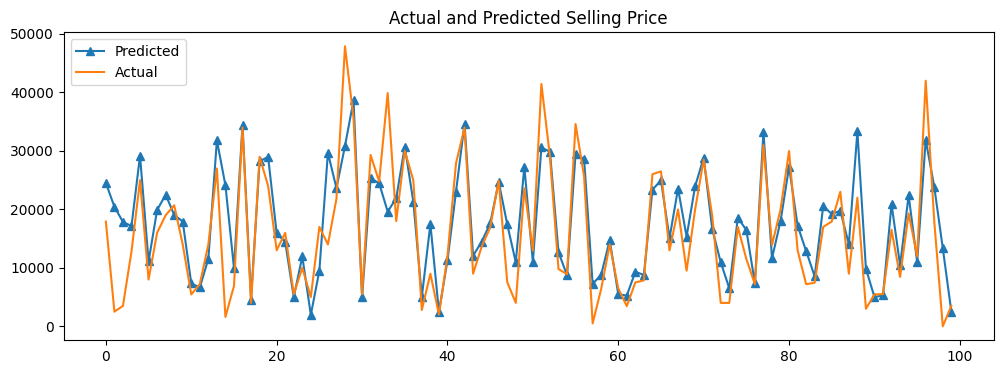

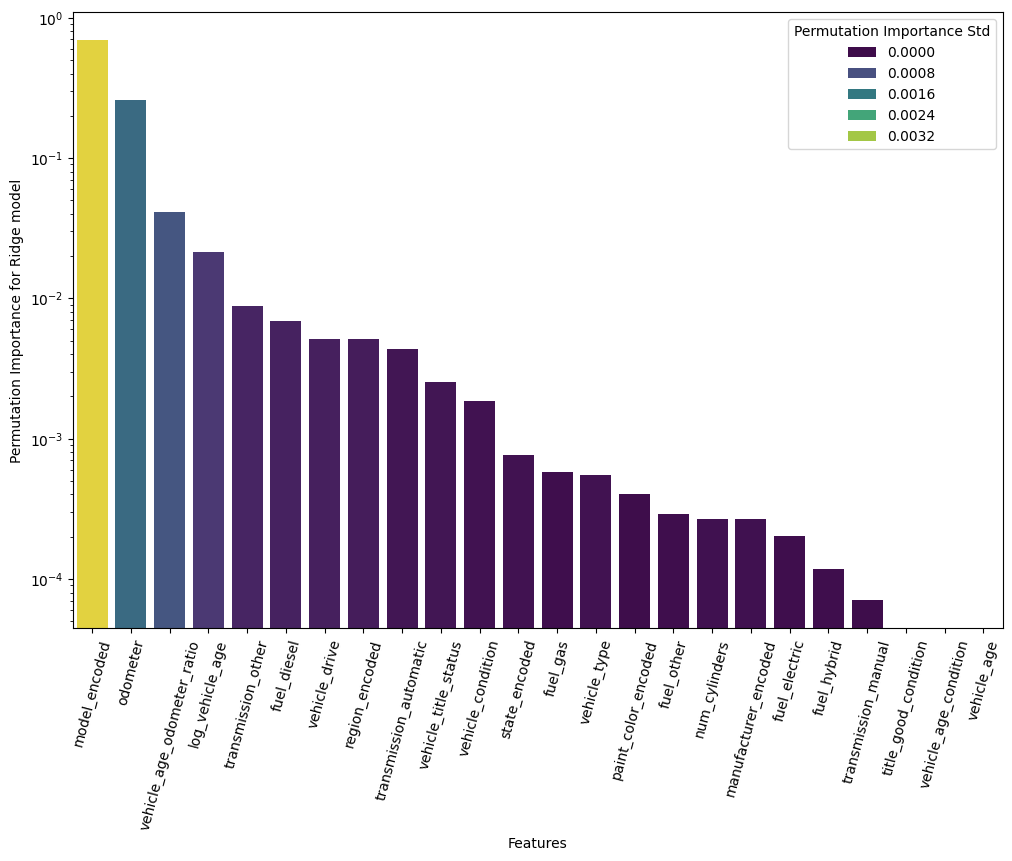

In [65]:
# Evaluate Ridge model
start_time = time.time()
ridge_score = evaluate_models(best_model_rcv, 'Ridge', y_test, X_test, y_train, X_train)
score['Ridge Regressor'] = ridge_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.3 Evaluate Lasso model</h4>

MSE Train: 49431444.68411369
MSE Test: 49067354.74263153
RMSE Train: 7030.749937532531
RMSE Test: 7004.8094008781945
MAE Train: 4720.706867635882
MAE Test: 4707.706859996312
R2 Train: 0.6839698287970235
R2 Test: 0.6848165971678094
Adjusted R2 Train: 0.6839435730840473
Adjusted R2 Test: 0.6847118299637434
🕒 Duration (seconds): 1.184851884841919


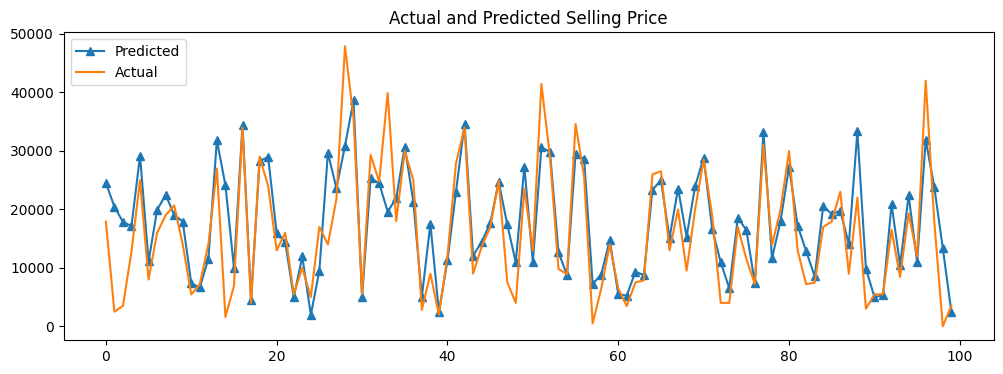

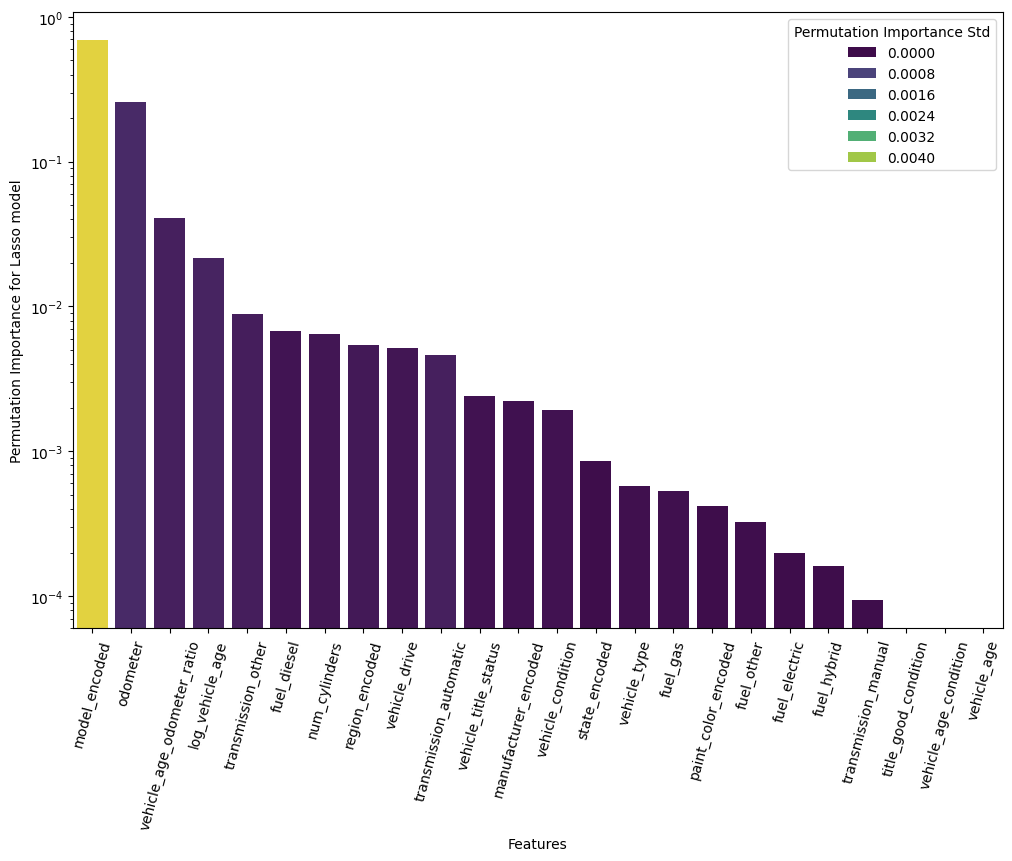

In [66]:
# Evaluate Lasso model
start_time = time.time()
lasso_score = evaluate_models(best_model_lcv, 'Lasso', y_test, X_test, y_train, X_train)
score['Lasso Regressor'] = lasso_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.4 Evaluate ElasticNet model</h4>

MSE Train: 49431506.29418045
MSE Test: 49066832.18239498
RMSE Train: 7030.754319003079
RMSE Test: 7004.772100675009
MAE Train: 4720.594391473287
MAE Test: 4707.6048669545335
R2 Train: 0.6839694349052392
R2 Test: 0.6848199538254978
Adjusted R2 Train: 0.6839431791595385
Adjusted R2 Test: 0.6847151877371873
🕒 Duration (seconds): 1.1689462661743164


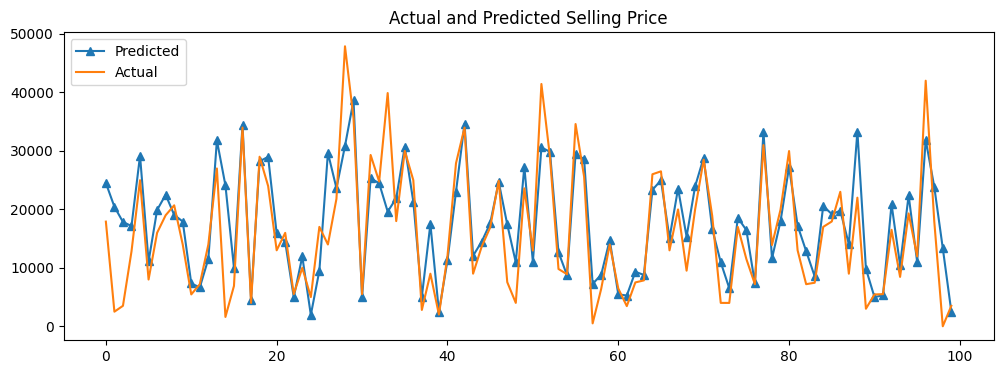

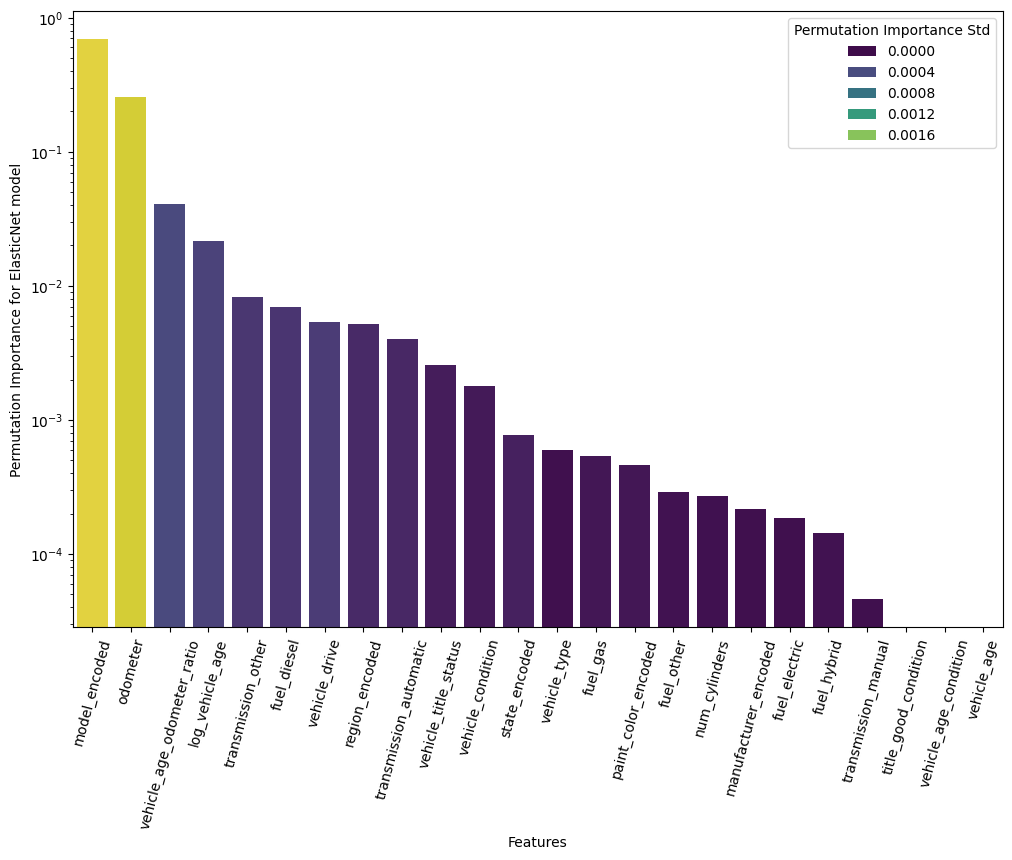

In [67]:
# Evaluate ElasticNet model
start_time = time.time()
elasticnet_score = evaluate_models(best_model_ecv, 'ElasticNet', y_test, X_test, y_train, X_train)
score['ElasticNet Regressor'] = elasticnet_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.5 Evaluate XGBRegressor model</h4>

MSE Train: 24853762.788546998
MSE Test: 27587133.910685487
RMSE Train: 4985.354830756482
RMSE Test: 5252.345562763887
MAE Train: 3080.8138673299504
MAE Test: 3205.3894056319423
R2 Train: 0.8411023800882969
R2 Test: 0.8227944671979102
Adjusted R2 Train: 0.8410891789110639
Adjusted R2 Test: 0.8227355639433293
🕒 Duration (seconds): 6.3357391357421875


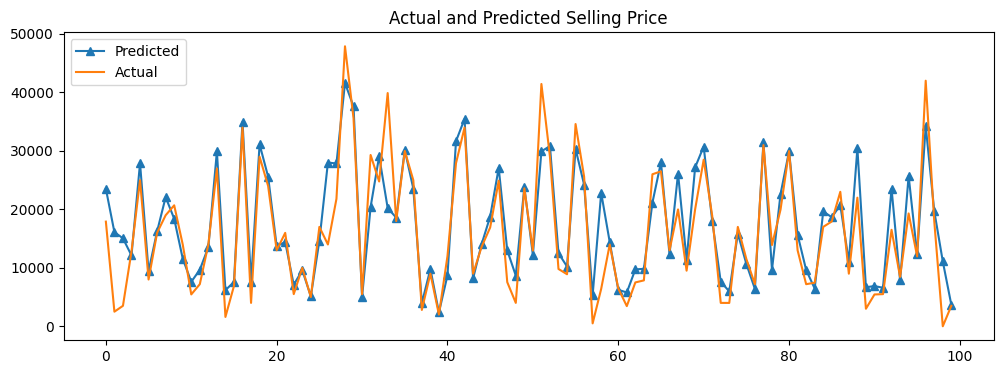

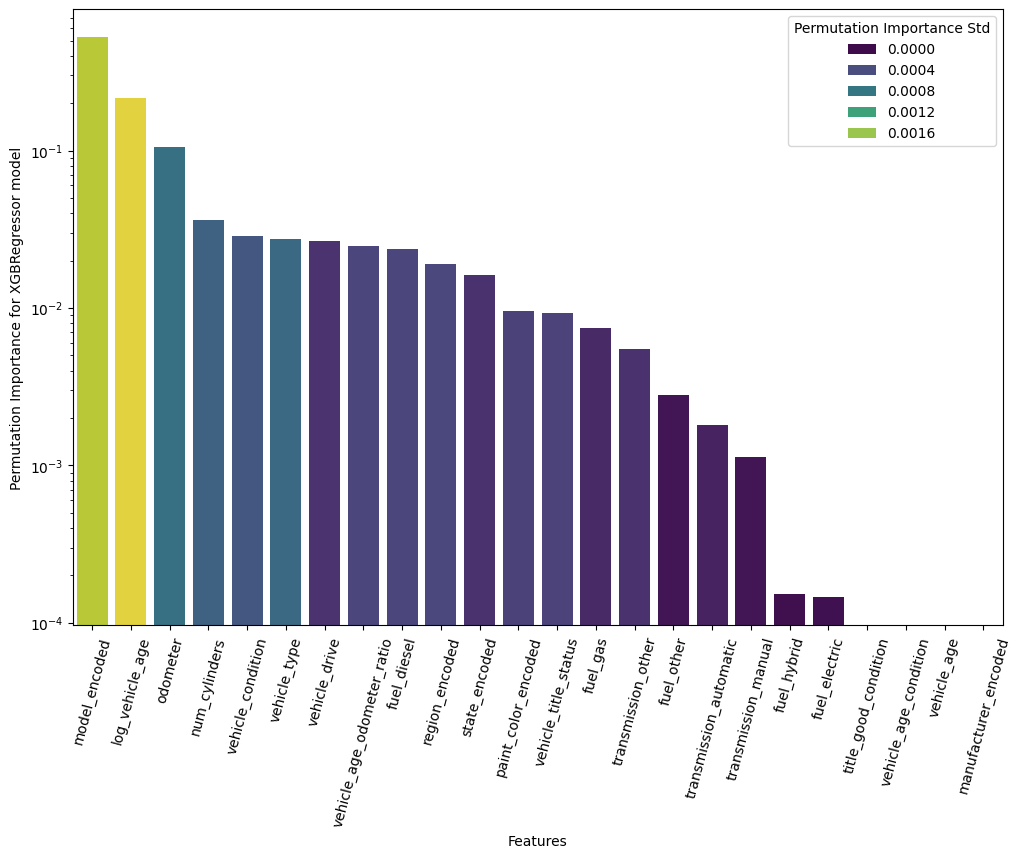

In [68]:
# Evaluate XGBRegressor model
start_time = time.time()
xgb_score = evaluate_models(best_model_xg, 'XGBRegressor', y_test, X_test, y_train, X_train)
score['XGBRegressor'] = xgb_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.6 Evaluate HistGradientBoostingRegressor model</h4>

MSE Train: 30271478.61092401
MSE Test: 31460203.795014884
RMSE Train: 5501.952254511485
RMSE Test: 5608.93963196386
MAE Train: 3449.6318045697035
MAE Test: 3498.072526817628
R2 Train: 0.8064652848179429
R2 Test: 0.7979158620244138
Adjusted R2 Train: 0.8064492059989067
Adjusted R2 Test: 0.797848689102453
🕒 Duration (seconds): 17.556430101394653


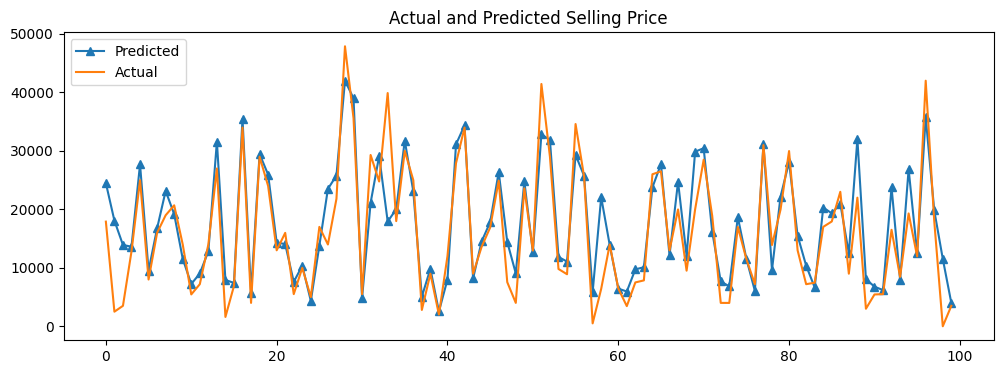

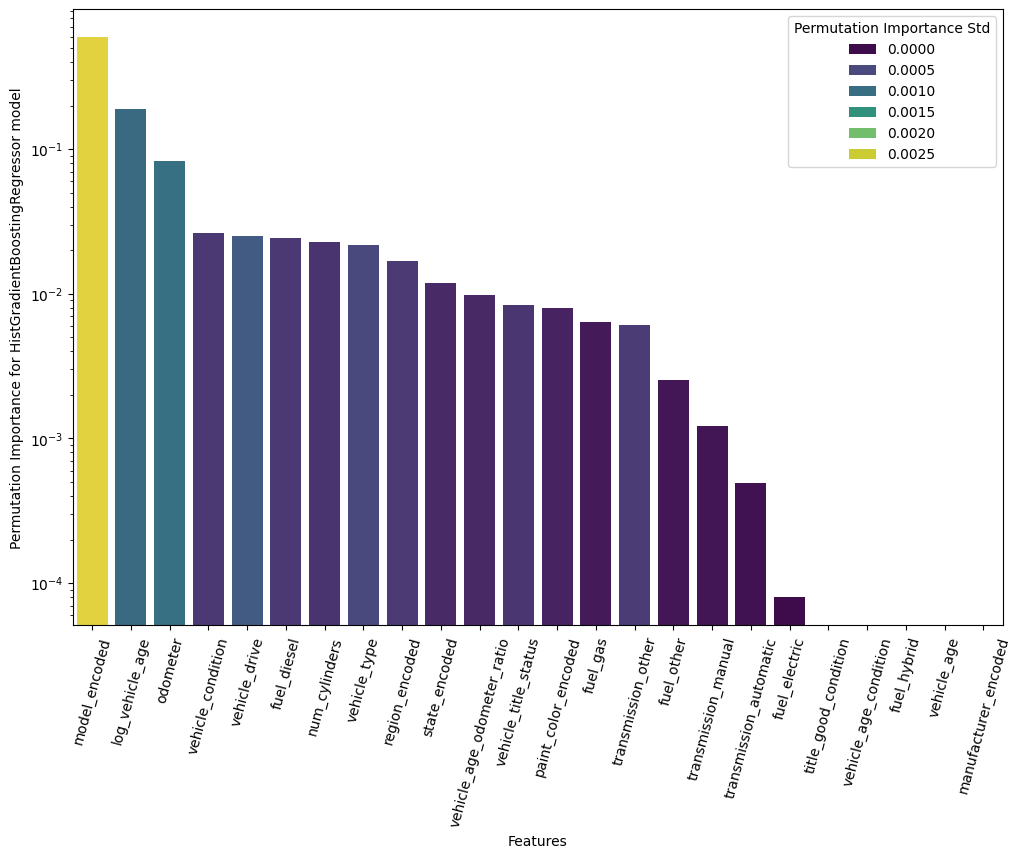

In [69]:
# Evaluate HistGradientBoostingRegressor model
start_time = time.time()
hgb_score = evaluate_models(best_model_hgb, 'HistGradientBoostingRegressor', y_test, X_test, y_train, X_train)
score['HistGradientBoosting Regressor'] = hgb_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.7 Evaluate DecisionTreeRegressor model</h4>

MSE Train: 17484122.820114538
MSE Test: 30705449.308950845
RMSE Train: 4181.402016084382
RMSE Test: 5541.2497966569645
MAE Train: 2351.5043470459846
MAE Test: 3100.859749596026
R2 Train: 0.8882187165783877
R2 Test: 0.8027640159236464
Adjusted R2 Train: 0.8882094298154104
Adjusted R2 Test: 0.8026984545317483
🕒 Duration (seconds): 2.450423002243042


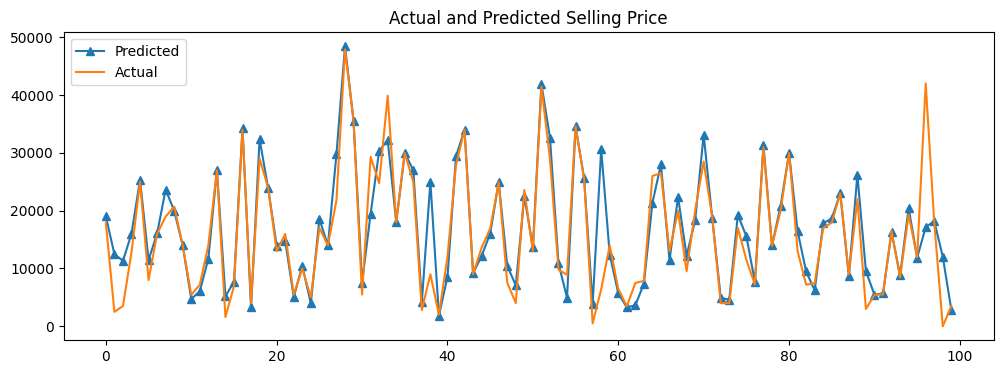

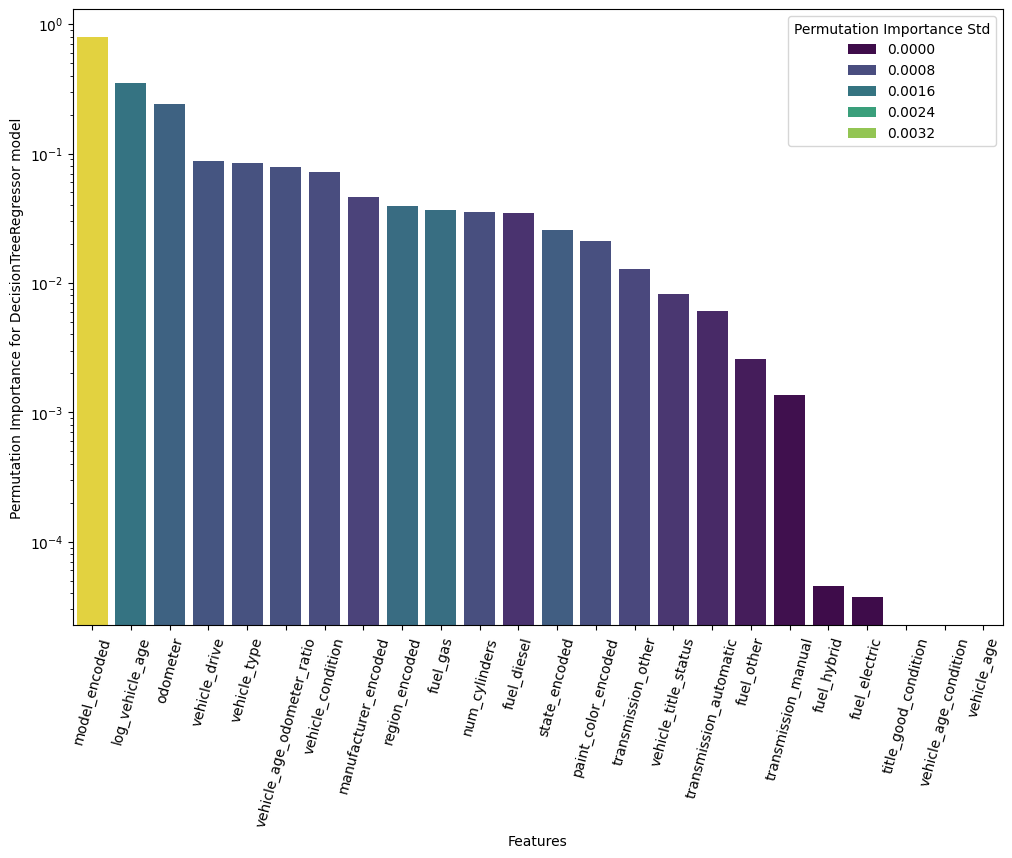

In [70]:
# Evaluate DecisionTreeRegressor model
start_time = time.time()
dt_score = evaluate_models(best_model_dt, 'DecisionTreeRegressor', y_test, X_test, y_train, X_train)
score['DecisionTreeRegressor'] = dt_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>Model Evaluation Scores</h4>

In [71]:
score

,Linear Regressor,Ridge Regressor,Lasso Regressor,ElasticNet Regressor,XGBRegressor,HistGradientBoosting Regressor,DecisionTreeRegressor
MSE Train,4.424175e+07,4.943145e+07,4.943144e+07,4.943151e+07,2.485376e+07,3.027148e+07,1.748412e+07
MSE Test,4.418990e+07,4.906716e+07,4.906735e+07,4.906683e+07,2.758713e+07,3.146020e+07,3.070545e+07
RMSE Train,6.651448e+03,7.030750e+03,7.030750e+03,7.030754e+03,4.985355e+03,5.501952e+03,4.181402e+03
RMSE Test,6.647548e+03,7.004796e+03,7.004809e+03,7.004772e+03,5.252346e+03,5.608940e+03,5.541250e+03
MAE Train,4.322278e+03,4.720666e+03,4.720707e+03,4.720594e+03,3.080814e+03,3.449632e+03,2.351504e+03
MAE Test,4.325726e+03,4.707671e+03,4.707707e+03,4.707605e+03,3.205389e+03,3.498073e+03,3.100860e+03
R2 Train,7.171491e-01,6.839698e-01,6.839698e-01,6.839694e-01,8.411024e-01,8.064653e-01,8.882187e-01
R2 Test,7.161469e-01,6.848178e-01,6.848166e-01,6.848200e-01,8.227945e-01,7.979159e-01,8.027640e-01
Adjusted R2 Train,7.171256e-01,6.839435e-01,6.839436e-01,6.839432e-01,8.410892e-01,8.064492e-01,8.882094e-01
Adjusted R2 Test,7.160525e-01,6.847131e-01,6.847118e-01,6.847152e-01,8.227356e-01,7.978487e-01,8.026985e-01


In [72]:
print(mse_train_models)
print(mse_test_models)

[44241754.23859767, 49431452.52738118, 49431444.68411369, 49431506.29418045, 24853762.788546998, 30271478.61092401, 17484122.820114538]
[44189895.969520666, 49067160.071148425, 49067354.74263153, 49066832.18239498, 27587133.910685487, 31460203.795014884, 30705449.308950845]


In [73]:
# DataFrame to record MSE for train and test for all models
mse_df = pd.DataFrame({
    'mse_train': mse_train_models,
    'mse_test': mse_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='mse_test', ascending=True)
mse_df = mse_df.reset_index()
mse_df.columns = ['Model', 'MSE Train', 'MSE Test']
mse_df.head()

,Model,MSE Train,MSE Test
0,XGBRegressor,2.485376e+07,2.758713e+07
1,DecisionTreeRegressor,1.748412e+07,3.070545e+07
2,HistGradient Boosting Regressor,3.027148e+07,3.146020e+07
3,LinearRegression,4.424175e+07,4.418990e+07
4,ElasticNet,4.943151e+07,4.906683e+07


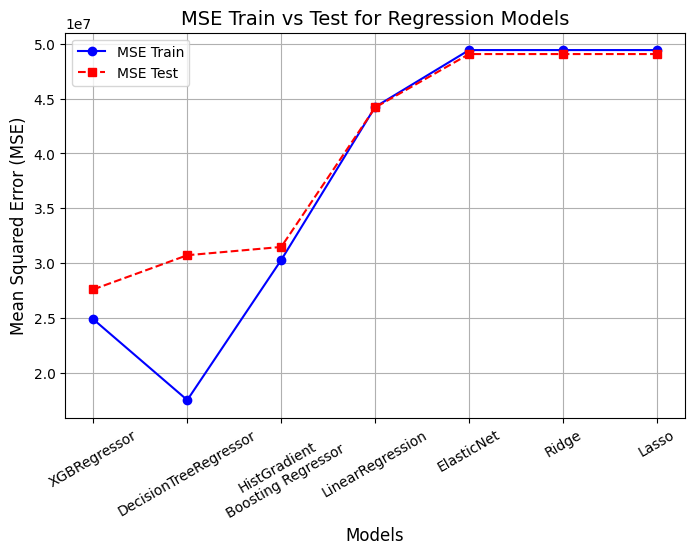

In [74]:
# Create Line Plot for MSE for all models
plt.figure(figsize=(8,5))
plt.plot(mse_df['Model'], mse_df['MSE Train'], marker='o', linestyle='-', label='MSE Train', color='blue')
plt.plot(mse_df['Model'], mse_df['MSE Test'], marker='s', linestyle='--', label='MSE Test', color='red')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(mse_df))
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title("MSE Train vs Test for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_mse_evaluation.png')
plt.show()

In [75]:
# DataFrame to record RMSE for train and test for all models
rmse_df = pd.DataFrame({
    'rmse_train': rmse_train_models,
    'rmse_test': rmse_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='rmse_test', ascending=True)
rmse_df = rmse_df.reset_index()
rmse_df.columns = ['Model', 'RMSE Train', 'RMSE Test']
rmse_df.head()

,Model,RMSE Train,RMSE Test
0,XGBRegressor,4985.354831,5252.345563
1,DecisionTreeRegressor,4181.402016,5541.249797
2,HistGradient Boosting Regressor,5501.952255,5608.939632
3,LinearRegression,6651.447530,6647.548117
4,ElasticNet,7030.754319,7004.772101


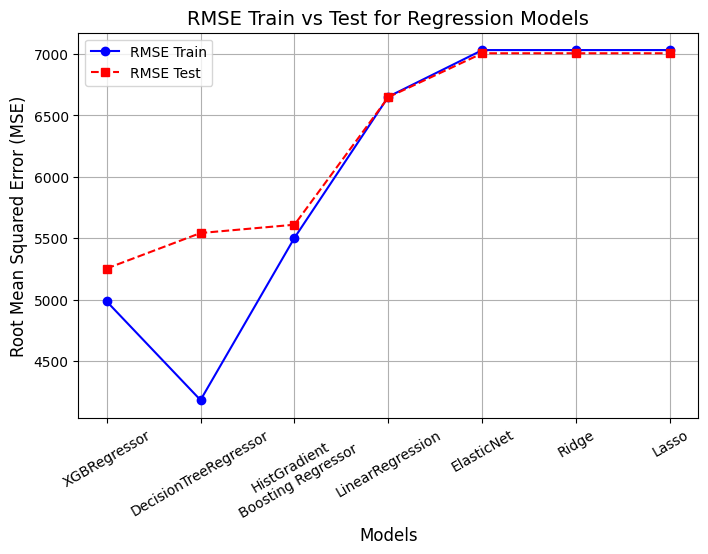

In [76]:
# Create Line Plot for MSE for all models
plt.figure(figsize=(8,5))
plt.plot(rmse_df['Model'], rmse_df['RMSE Train'], marker='o', linestyle='-', label='RMSE Train', color='blue')
plt.plot(rmse_df['Model'], rmse_df['RMSE Test'], marker='s', linestyle='--', label='RMSE Test', color='red')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(rmse_df))
plt.ylabel("Root Mean Squared Error (MSE)", fontsize=12)
plt.title("RMSE Train vs Test for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_rmse_evaluation.png')
plt.show()

In [77]:
# DataFrame to record MAE for train and test for all models
mae_df = pd.DataFrame({
    'mae_train': mae_train_models,
    'mae_test': mae_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='mae_test', ascending=True)
mae_df = mae_df.reset_index()
mae_df.columns = ['Model', 'MAE Train', 'MAE Test']
mae_df.head()

,Model,MAE Train,MAE Test
0,DecisionTreeRegressor,2351.504347,3100.859750
1,XGBRegressor,3080.813867,3205.389406
2,HistGradient Boosting Regressor,3449.631805,3498.072527
3,LinearRegression,4322.278166,4325.726016
4,ElasticNet,4720.594391,4707.604867


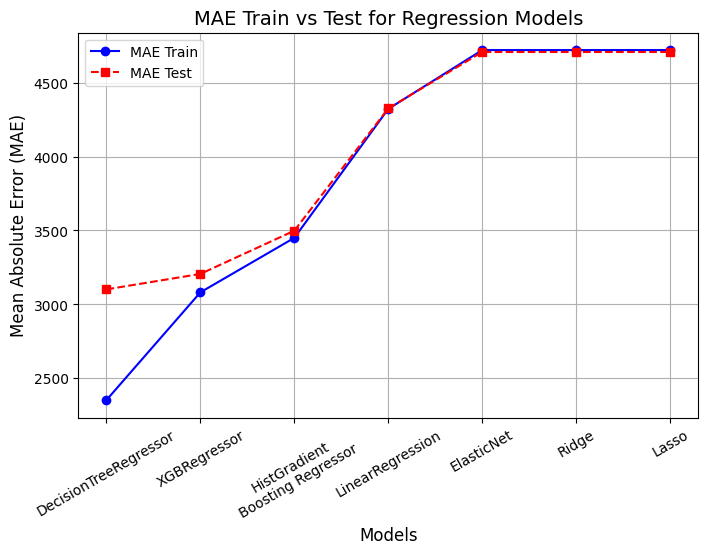

In [78]:
# Create Line Plot for MAE for all models
plt.figure(figsize=(8,5))
plt.plot(mae_df['Model'], mae_df['MAE Train'], marker='o', linestyle='-', label='MAE Train', color='blue')
plt.plot(mae_df['Model'], mae_df['MAE Test'], marker='s', linestyle='--', label='MAE Test', color='red')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(mae_df))
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("MAE Train vs Test for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_mae_evaluation.png')
plt.show()

In [79]:
# DataFrame to record R2 Score for train and test for all models
r2_df = pd.DataFrame({
    'r2_train': r2_train_models,
    'r2_test': r2_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='r2_test', ascending=True)
r2_df = r2_df.reset_index()
r2_df.columns = ['Model', 'R2 Score Train', 'R2 Score Test']
r2_df.head()

,Model,R2 Score Train,R2 Score Test
0,Lasso,0.683970,0.684817
1,Ridge,0.683970,0.684818
2,ElasticNet,0.683969,0.684820
3,LinearRegression,0.717149,0.716147
4,HistGradient Boosting Regressor,0.806465,0.797916


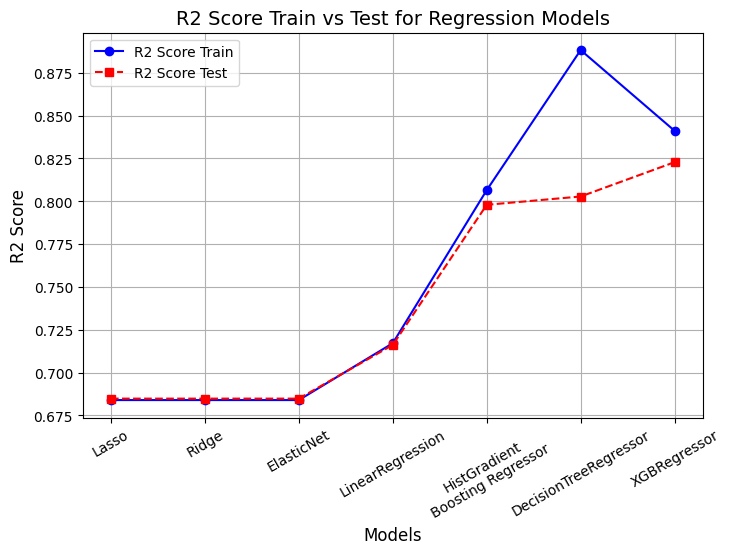

In [80]:
# Create Line Plot for R2 Score for all models
plt.figure(figsize=(8,5))
plt.plot(r2_df['Model'], r2_df['R2 Score Train'], marker='o', linestyle='-', label='R2 Score Train', color='blue')
plt.plot(r2_df['Model'], r2_df['R2 Score Test'], marker='s', linestyle='--', label='R2 Score Test', color='red')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(r2_df))
plt.ylabel("R2 Score", fontsize=12)
plt.title("R2 Score Train vs Test for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_r2_evaluation.png')
plt.show()

### Summary of Model Evaluation

* Defined model evaluation method which will perform multiple tasks as below:
  * Calculate MSE, RMSE, MAE, R2 score for train and test target variable.
  * Plot line chart for actual and predicted target price values.
  * Calculate permutation importance of feature and plot a bar graph in the order of importance of features.
* Perform model evalaution for each of the 6 models based on errors.
* Plot line chart of MSE train and MSE test for each of the models trained.

#### Evaluation Adjustment
* We did few adjustments during multiple iterations of fixing issues and fine tuning model.
  * Data Leakage Issue
    * Price imputation cause data leakage to the model. Due to which we saw R2 score of 0.99.
  * Model Accuracy Improvement
    * Orginally tried 4 regression models (LinearRegression, Ridge, Lasso and ElasticNet) and R2 score was 0.53
    * Tried 2 additional models (XGBoostRegressor and HistGradientBoostingRegressor) which improved R2 score to 0.82 and 0.8 for test data respectively.

### 5. Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [81]:
from joblib import dump, load
# Save the models to a joblib file

def save_models():
    dump(best_model_lr, 'models/lr_model.joblib')
    dump(best_model_rcv, 'models/ridge_model.joblib')
    dump(best_model_lcv, 'models/lasso_model.joblib')
    dump(best_model_ecv, 'models/lasticnet_model.joblib')
    dump(best_model_xg, 'models/xgb_model.joblib')
    dump(best_model_hgb, 'models/hgb_model.joblib')
    dump(best_model_dt, 'models/dt_model.joblib')

save_models()

In [82]:
# Function to load the model from joblib file and calculate errors
mse_valid_models = []
mae_valid_models = []
r2_valid_models = []

def load_and_predict(model_name):
    X_valid = data_valid.drop('price', axis=1)
    y_valid = data_valid['price']

    load_model = None
    if model_name == 'LinearRegression':
        load_model = load('models/lr_model.joblib')
    elif model_name == 'Ridge':
        load_model = load('models/ridge_model.joblib')
    elif model_name == 'Lasso':
        load_model = load('models/lasso_model.joblib')
    elif model_name == 'ElasticNet':
        load_model = load('models/lasticnet_model.joblib')
    elif model_name == 'XGBRegressor':
        load_model = load('models/xgb_model.joblib')
    elif model_name == 'HistGradientBoostingRegressor':
        load_model = load('models/hgb_model.joblib')
    elif model_name == 'DecisionTreeRegressor':
        load_model = load('models/dt_model.joblib')
    
    new_test_preds = load_model.predict(X_valid)
    # Sanity Check
    mse = mean_squared_error(y_valid, new_test_preds)
    mae = mean_absolute_error(y_valid, new_test_preds)
    r2 = r2_score(y_valid, new_test_preds)
    mse_valid_models.append(mse)
    mae_valid_models.append(mae)
    r2_valid_models.append(r2)
    print(f"MSE for {model_name}:", mse)
    print(f"MAE for {model_name}:", mae)
    print(f"R2 for {model_name}:", r2)

In [83]:
load_and_predict('LinearRegression')

MSE for LinearRegression: 44845350.373921886
MAE for LinearRegression: 4348.091855652491
R2 for LinearRegression: 0.71261547791479


In [84]:
load_and_predict('Ridge')

MSE for Ridge: 50031056.98276767
MAE for Ridge: 4746.476336169756
R2 for Ridge: 0.6793836756648095


In [85]:
load_and_predict('Lasso')

MSE for Lasso: 50031284.56471923
MAE for Lasso: 4746.5169975139115
R2 for Lasso: 0.6793822172409185


In [86]:
load_and_predict('ElasticNet')

MSE for ElasticNet: 50030664.775218815
MAE for ElasticNet: 4746.401490654587
R2 for ElasticNet: 0.6793861890664898


In [87]:
load_and_predict('XGBRegressor')

MSE for XGBRegressor: 27933416.40163687
MAE for XGBRegressor: 3232.1494805504576
R2 for XGBRegressor: 0.8209930024883975


In [88]:
load_and_predict('HistGradientBoostingRegressor')

MSE for HistGradientBoostingRegressor: 31939871.135250248
MAE for HistGradientBoostingRegressor: 3519.5222218647277
R2 for HistGradientBoostingRegressor: 0.795318254286518


In [89]:
load_and_predict('DecisionTreeRegressor')

MSE for DecisionTreeRegressor: 31298755.569769796
MAE for DecisionTreeRegressor: 3139.505494918174
R2 for DecisionTreeRegressor: 0.7994267446617906


In [90]:
# DataFrame to record MSE for test and validation for all models
v_mse_df = pd.DataFrame({
    'mse_test': mse_test_models,
    'mse_valid': mse_valid_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='mse_valid', ascending=True)
v_mse_df = v_mse_df.reset_index()
v_mse_df.columns = ['Model', 'MSE Test', 'MSE Validation']
v_mse_df.head()

,Model,MSE Test,MSE Validation
0,XGBRegressor,2.758713e+07,2.793342e+07
1,DecisionTreeRegressor,3.070545e+07,3.129876e+07
2,HistGradient Boosting Regressor,3.146020e+07,3.193987e+07
3,LinearRegression,4.418990e+07,4.484535e+07
4,ElasticNet,4.906683e+07,5.003066e+07


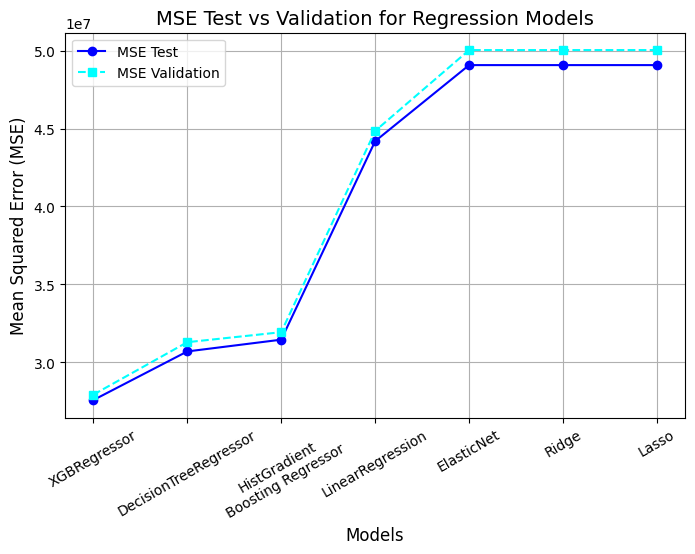

In [91]:
# Create Line Plot for MSE for all models
plt.figure(figsize=(8,5))
plt.plot(v_mse_df['Model'], v_mse_df['MSE Test'], marker='o', linestyle='-', label='MSE Test', color='blue')
plt.plot(v_mse_df['Model'], v_mse_df['MSE Validation'], marker='s', linestyle='--', label='MSE Validation', color='cyan')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(v_mse_df))
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title("MSE Test vs Validation for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_mse_evaluation_for_validation.png')
plt.show()

In [92]:
# DataFrame to record MAE for test and validation for all models
v_mae_df = pd.DataFrame({
    'mae_test': mae_test_models,
    'mae_valid': mae_valid_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='mae_valid', ascending=True)
v_mae_df = v_mae_df.reset_index()
v_mae_df.columns = ['Model', 'MAE Test', 'MAE Validation']
v_mae_df.head()

,Model,MAE Test,MAE Validation
0,DecisionTreeRegressor,3100.859750,3139.505495
1,XGBRegressor,3205.389406,3232.149481
2,HistGradient Boosting Regressor,3498.072527,3519.522222
3,LinearRegression,4325.726016,4348.091856
4,ElasticNet,4707.604867,4746.401491


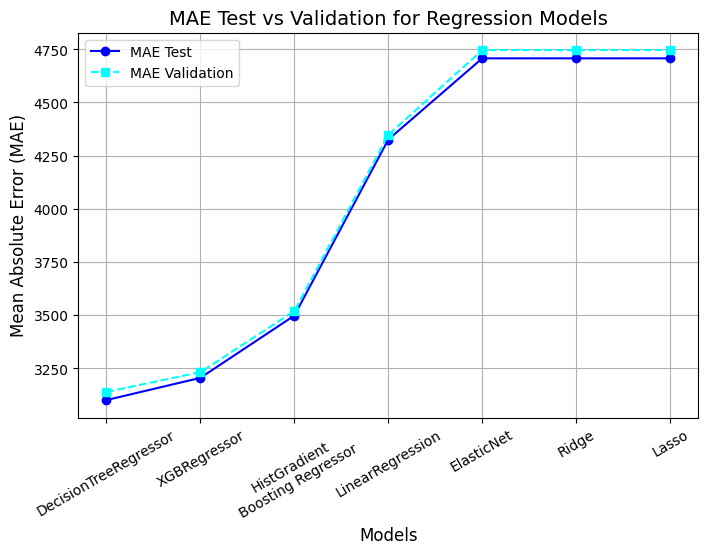

In [93]:
# Create Line Plot for MAE for all models
plt.figure(figsize=(8,5))
plt.plot(v_mae_df['Model'], v_mae_df['MAE Test'], marker='o', linestyle='-', label='MAE Test', color='blue')
plt.plot(v_mae_df['Model'], v_mae_df['MAE Validation'], marker='s', linestyle='--', label='MAE Validation', color='cyan')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(v_mae_df))
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("MAE Test vs Validation for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_mae_evaluation_for_validation.png')
plt.show()

In [94]:
# DataFrame to record R2 Score for test and validation for all models
v_r2_df = pd.DataFrame({
    'r2_test': r2_test_models,
    'r2_valid': r2_valid_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'HistGradient Boosting Regressor', 'DecisionTreeRegressor']).sort_values(by='r2_valid', ascending=True)
v_r2_df = v_r2_df.reset_index()
v_r2_df.columns = ['Model', 'R2 Score Test', 'R2 Score Validation']
v_r2_df.head()

,Model,R2 Score Test,R2 Score Validation
0,Lasso,0.684817,0.679382
1,Ridge,0.684818,0.679384
2,ElasticNet,0.684820,0.679386
3,LinearRegression,0.716147,0.712615
4,HistGradient Boosting Regressor,0.797916,0.795318


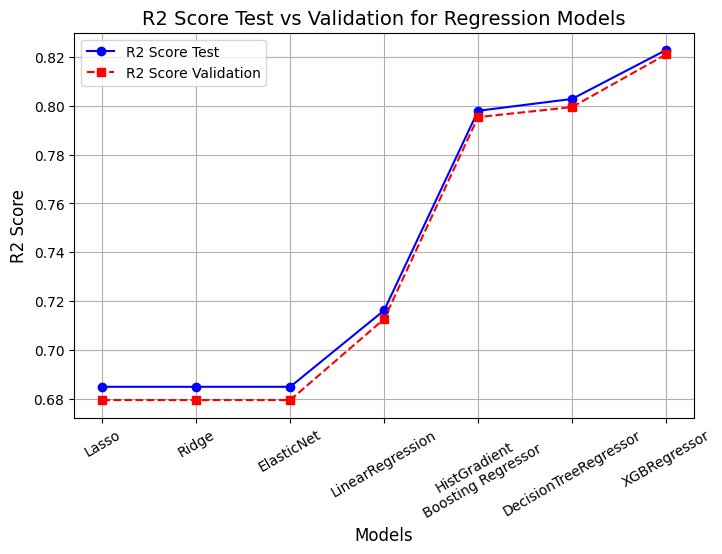

In [95]:
# Create Line Plot for R2 Score for all models
plt.figure(figsize=(8,5))
plt.plot(v_r2_df['Model'], v_r2_df['R2 Score Test'], marker='o', linestyle='-', label='R2 Score Test', color='blue')
plt.plot(v_r2_df['Model'], v_r2_df['R2 Score Validation'], marker='s', linestyle='--', label='R2 Score Validation', color='red')

# Add Labels & Title
plt.xlabel("Models", fontsize=12)
wrap_labels(plt.gca(), 20, len(v_r2_df))
plt.ylabel("R2 Score", fontsize=12)
plt.title("R2 Score Test vs Validation for Regression Models", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.savefig('images/model_r2_evaluation_for_validation.png')
plt.show()

### Summary of Model Deployment

* Utilized joblib library to dump and load model
* Used validation data set (unseen data) to validate model performance and observed consistency with training results.

In [96]:
nb_end_time = time.time()
print("🕒 Duration to run notebook (minutes):", (nb_end_time - nb_start_time) / 60)

🕒 Duration to run notebook (minutes): 13.88289053440094


<H3>Final summary is available in README.md</H3>